In [13]:
# Load modules for data management
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter

# Import necessary modules for classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Set figure DPI for publication quality for matplotlib.pyplot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# ...and seaborn
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sns.set_style('white')


In [14]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("SEEROutput.csv",low_memory=False)
# Look at data header
# display(salivary_df.head())
display(salivary_df.info())
display(salivary_df.columns)

small_df = salivary_df.sample(1000)
small_df.to_csv('output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28030 entries, 0 to 28029
Data columns (total 64 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   Patient ID                                                 28030 non-null  int64 
 1   Age recode with <1 year olds                               28030 non-null  object
 2   Sex                                                        28030 non-null  object
 3   Year of diagnosis                                          28030 non-null  int64 
 4   PRCDA 2020                                                 28030 non-null  object
 5   Race recode (W, B, AI, API)                                28030 non-null  object
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    28030 non-null  object
 7   Site recode ICD-O-3/WHO 2008                               28030 non-null  object
 8   Behavior code IC

None

Index(['Patient ID', 'Age recode with <1 year olds', 'Sex',
       'Year of diagnosis', 'PRCDA 2020', 'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3',
       'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
       'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
       'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
       'ICD-O-3 Hist/behav, malignant', 'Histology recode - broad groupings',
       'Site recode ICD-O-3/WHO 2008 (for SIRs)',
       'Combined Summary Stage (2004+)', 'Summary stage 2000 (1998-2017)',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'SEER historic stage A (1973-2015)', 'RX Summ--Surg Prim Site (1998+)',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
       'Reason no can

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we may need to address missing values individually. They may be logged as, for example, 'XX' or '99' or 'Unknown'. As such, we will always view unique values in each column before evaluations and strive to identify anything that may be a missing value.


# Data Cleaning: Categorical Adjustments and  Orders Including Histology and Grade 

Primary Site - labeled
C07.9-Parotid gland                                  22709
C08.0-Submandibular gland                             3628
C08.9-Major salivary gland, NOS                       1420
C08.1-Sublingual gland                                 250
C08.8-Overlapping lesion of major salivary glands       23
Name: count, dtype: int64

In [16]:
# Select relevant columns for demographic analysis
age_colname = 'Age recode with single ages and 90+'
age_bin_colname = 'Age_Binned'
race_colname = 'Race recode (W, B, AI, API)'
sex_colname = 'Sex'
ses_colname = 'Median household income inflation adj to 2022'
site_colname = 'Primary Site - labeled'
marital_colname = 'Marital status at diagnosis'

# Define a function to extract numerical values from median income
def extract_midpoint(income_str):
    # Check if the income string represents an open-ended range (e.g., "$120,000+")
    income_str = income_str.replace(',','')
    if '+' in income_str:
        # Extract the number before the '+' and return it as a float
        return float(re.sub(r'[^\d]', '', income_str))

    # Check if the income string represents a range (e.g., "$40,000 - $44,999")
    elif '-' in income_str:
        # Extract the two numbers and calculate the midpoint
        numbers = re.findall(r'\d+', income_str)
        lower_bound = float(numbers[0])
        upper_bound = float(numbers[1])
        midpoint = (lower_bound + upper_bound) / 2
        return midpoint

    # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
    elif '<' in income_str:
        # Extract the number and treat it as the threshold value
        return float(re.sub(r'[^\d]', '', income_str))

    # If the string does not match any of the patterns, return NaN
    return np.nan

# Apply the function to the income column
salivary_df['Income_numeric'] = salivary_df['Median household income inflation adj to 2022'].apply(extract_midpoint)
salivary_df['Income_numeric'] = salivary_df['Income_numeric'].astype('double')
# Step 3: Create a new column with quartile assignments
salivary_df['Income_quartile'] = pd.qcut(salivary_df['Income_numeric'], q=4, labels=["Lowest quartile", "Lower middle quartile", "Upper middle quartile", "Highest quartile"])
# salivary_df['Income_quartile'] = salivary_df['Income_quartile'].cat.reorder_categories(['Highest quartile','Upper middle quartile','Lower middle quartile','Lowest quartile'],ordered=True)

# Perform the quartile cut and directly assign to a new variable to examine the Categorical object
quartile_cut = pd.qcut(salivary_df['Income_numeric'], q=4)

# Access the categories (intervals) from the Categorical object
quartile_bins = quartile_cut.cat.categories

demographic_columns = [age_colname,race_colname,sex_colname, ses_colname]

# Remove 'years'
salivary_df[age_colname] = salivary_df[age_colname].str.replace(' years','') 

# Organize age column as a categorical with numerical order
numerical_years = salivary_df[age_colname].str.extract(r'(\d+)').astype(float)
# print(numerical_years[0].unique())
# Input numerical age data into the dataframe
salivary_df['Numerical_Age'] = numerical_years


# Define 5-year bins from 0 to 90+, using float to allow for infinity in the final bin
bins = np.concatenate([np.arange(0, 95, 5), [np.inf]])  # Include infinity in the last bin

# Create labels for the bins, including '90+' for the last bin
labels = [f'{i}-{i+4}' for i in range(0, 90, 5)] + ['90+']

# Apply pd.cut to create the binned age categories
salivary_df[age_bin_colname] = pd.cut(salivary_df['Numerical_Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Check the unique values of the new binned age column
# print(salivary_df[age_bin_colname].unique())
# Create a mapping for values with leading zeros and handle special cases:
# - Convert '00' and '<1' to '≤1'
# - Remove leading zeros for values like '02', '03', etc.
# - Leave '90' as it is

sorted_ages = salivary_df[age_colname].unique()
age_mapping = {
    age: '≤1' if age == '00' or age == '<1' else (str(int(age)) if age.isdigit() and int(age) < 10 else age)
    for age in sorted_ages
}

# Replace values in the age column using the mapping
salivary_df[age_colname] = salivary_df[age_colname].replace(age_mapping)

# Get the sorted unique ages after the mapping has been applied
# Ensure '≤1' comes first by assigning key paramter = -1
# Otherwise: get rid of "+" at the end of 90
sorted_ages = sorted(
    salivary_df[age_colname].unique(),
    key=lambda x: (-1 if '≤1' in x else float(x.replace('+', '').replace('≤', '').replace('<', ''))) if x != '90+' else 90
)

# Convert the 'age_colname' column to categorical with sorted order
salivary_df[age_colname] = pd.Categorical(salivary_df[age_colname], categories=sorted_ages, ordered=True)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df[sex_colname] = pd.Categorical(
    salivary_df[sex_colname], categories=sex_order, ordered=True
)

# Race order
race_order = ['White','Black','Asian or Pacific Islander','American Indian/Alaskan Native','Unknown']

# Convert race column to reflect new world order
salivary_df[race_colname] = pd.Categorical(
    salivary_df[race_colname], categories=race_order, ordered=True
)

# display(salivary_df[age_colname].unique)


# SES
# Define the order of categories
socioeconomic_order = [
    "<$40,000", "$40,000 - $44,999", "$45,000 - $49,999", "$50,000 - $54,999",
    "$55,000 - $59,999", "$60,000 - $64,999", "$65,000 - $69,999", "$70,000 - $74,999",
    "$75,000 - $79,999", "$80,000 - $84,999", "$85,000 - $89,999", "$90,000 - $94,999",
    "$95,000 - $99,999", "$100,000 - $109,999", "$110,000 - $119,999", "$120,000+"
]

# Change to categorical
salivary_df[ses_colname] = pd.Categorical(
    salivary_df[ses_colname],
    categories=socioeconomic_order,
    ordered=True
)

# Marital mapping
marital_map = {'Divorced':'Divorced/Separated',
               'Separated':'Divorced/Separated',
               'Married (including common law)':'Married',
               'Single (never married)':'Single',
               'Unmarried or Domestic Partner':'Domestic Partner'}

salivary_df[marital_colname] = salivary_df[marital_colname].replace(marital_map).astype('category')
marital_order = ['Married', 'Single', 'Divorced/Separated', 'Widowed', 'Domestic Partner','Unknown']

salivary_df[marital_colname] = pd.Categorical(salivary_df[marital_colname], categories=marital_order, ordered=True)


print(salivary_df[marital_colname].unique())
# Categorize histological types - based on Baddour, JAMA Otolaryngol Head Neck Surg, 2015
mec_code = ['8430']
acc_code = ['8200']
adenocarcinoma_code = ['8140','8147','8290','8310','8410','8440','8480','8525','8550']
mixed_code = ['8980','8981']
rare_code = ['8012','8041','8082','8562','8982']

all_codes = mec_code + acc_code + adenocarcinoma_code + mixed_code + rare_code

# Function to map each code to a category
def categorize_histology(code):
    if code in mec_code:
        return 'Mucoepidermoid Carcinoma'
    elif code in acc_code:
        return 'Adenoid Cystic Carcinoma'
    elif code in adenocarcinoma_code:
        return 'Adenocarcinoma'
    elif code in mixed_code:
        return 'Mixed Subtypes'
    elif code in rare_code:
        return 'Other Rare Types'
    else:
        return 'Other'

# Extract 4 digit ICD-O-3 Code:
salivary_df['ICD-O-3 Code'] = salivary_df['ICD-O-3 Hist/behav'].str.extract(r'(\d{4})')

# Filter the DataFrame to include only rows where the 'ICD-O-3 Code' is in your list of codes
filtered_df = salivary_df[salivary_df['ICD-O-3 Code'].isin(all_codes)]

# Use assign to apply the histology categorization
filtered_df = filtered_df.assign(Histology=filtered_df['ICD-O-3 Code'].apply(categorize_histology))

# View the filtered DataFrame
# display(filtered_df[['ICD-O-3 Code', 'ICD-O-3 Hist/behav', 'Histology']])
# Define the ordered grade labels
grade_order = ['Grade I', 'Grade II', 'Grade III', 'Grade IV', 'Unknown']

# Grade Mapping
grade_mapping = {'Unknown':'Unknown',
 'Moderately differentiated; Grade II':'Grade II',
 'Well differentiated; Grade I': 'Grade I',
 'Poorly differentiated; Grade III': 'Grade III',
 'Undifferentiated; anaplastic; Grade IV': 'Grade IV'}

# apply mapping + convert to categorical
filtered_df['Grade Label'] = filtered_df['Grade Recode (thru 2017)'].map(grade_mapping)
filtered_df['Grade Label'] = pd.Categorical(filtered_df['Grade Label'], categories=grade_order, ordered=True)

# Grade Level Mapping
grade_level_mapping = {'Unknown':'Unknown',
                 'Moderately differentiated; Grade II':'Intermediate',
                 'Well differentiated; Grade I': 'Low',
                 'Poorly differentiated; Grade III': 'High',
                 'Undifferentiated; anaplastic; Grade IV': 'High'}

# apply mapping + convert to categorical
filtered_df['Grade Level'] = filtered_df['Grade Recode (thru 2017)'].map(grade_level_mapping)
filtered_df['Grade Level'] = pd.Categorical(filtered_df['Grade Level'], categories=['Low','Intermediate','High','Unknown'], ordered=True)
display(filtered_df)



Patient ID Age recode with <1 year olds     Sex  Year of diagnosis  \
0            1154                  75-79 years    Male               2016   
3            4395                  65-69 years  Female               2019   
5            5648                    85+ years    Male               2004   
6            6248                  25-29 years  Female               2004   
7            9663                  45-49 years    Male               2019   
...           ...                          ...     ...                ...   
28014    63331700                  70-74 years  Female               2021   
28015    63332021                  65-69 years    Male               2021   
28020    63332424                  55-59 years  Female               2021   
28024    63339600                  45-49 years    Male               2021   
28025    63340588                  60-64 years  Female               2020   

      PRCDA 2020 Race recode (W, B, AI, API)  \
0      Not PRCDA                       White   
3      Not PRCDA                       White   
5      Not PRCDA                       White   
6      Not PRCDA                       White   
7      Not PRCDA                       White   
...          ...                         ...   
28014  Not PRCDA                       White   
28015  Not PRCDA                       Black   
28020  Not PRCDA                       White   
28024  Not PRCDA                       White   
28025  Not PRCDA                       White   

      Origin recode NHIA (Hispanic, Non-Hisp) Site recode ICD-O-3/WHO 2008  \
0                 Non-Spanish-Hispanic-Latino               Salivary Gland   
3                 Non-Spanish-Hispanic-Latino               Salivary Gland   
5                 Non-Spanish-Hispanic-Latino               Salivary Gland   
6                 Non-Spanish-Hispanic-Latino               Salivary Gland   
7                     Spanish-Hispanic-Latino               Salivary Gland   
...                                       ...                          ...   
28014                 Spanish-Hispanic-Latino               Salivary Gland   
28015             Non-Spanish-Hispanic-Latino               Salivary Gland   
28020             Non-Spanish-Hispanic-Latino               Salivary Gland   
28024             Non-Spanish-Hispanic-Latino               Salivary Gland   
28025             Non-Spanish-Hispanic-Latino               Salivary Gland   

      Behavior code ICD-O-3 Primary Site - labeled  ...  \
0                 Malignant          Parotid gland  ...   
3                 Malignant          Parotid gland  ...   
5                 Malignant          Parotid gland  ...   
6                 Malignant          Parotid gland  ...   
7                 Malignant          Parotid gland  ...   
...                     ...                    ...  ...   
28014             Malignant          Parotid gland  ...   
28015             Malignant          Parotid gland  ...   
28020             Malignant          Parotid gland  ...   
28024             Malignant    Submandibular gland  ...   
28025             Malignant          Parotid gland  ...   

       Median household income inflation adj to 2022  \
0                                          $120,000+   
3                                          $120,000+   
5                                $110,000 - $119,999   
6                                  $95,000 - $99,999   
7                                $110,000 - $119,999   
...                                              ...   
28014                              $75,000 - $79,999   
28015                              $75,000 - $79,999   
28020                                      $120,000+   
28024                              $50,000 - $54,999   
28025                              $65,000 - $69,999   

                              Rural-Urban Continuum Code Income_numeric  \
0        Counties in metropolitan areas ge 1 million pop       120000.0   
3        Counties in metropolitan ar

# Race v. Age; Sex v. Age; Income Distribution

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/2385214494.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/2385214494.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/2385214494.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/2385214494.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xtickla

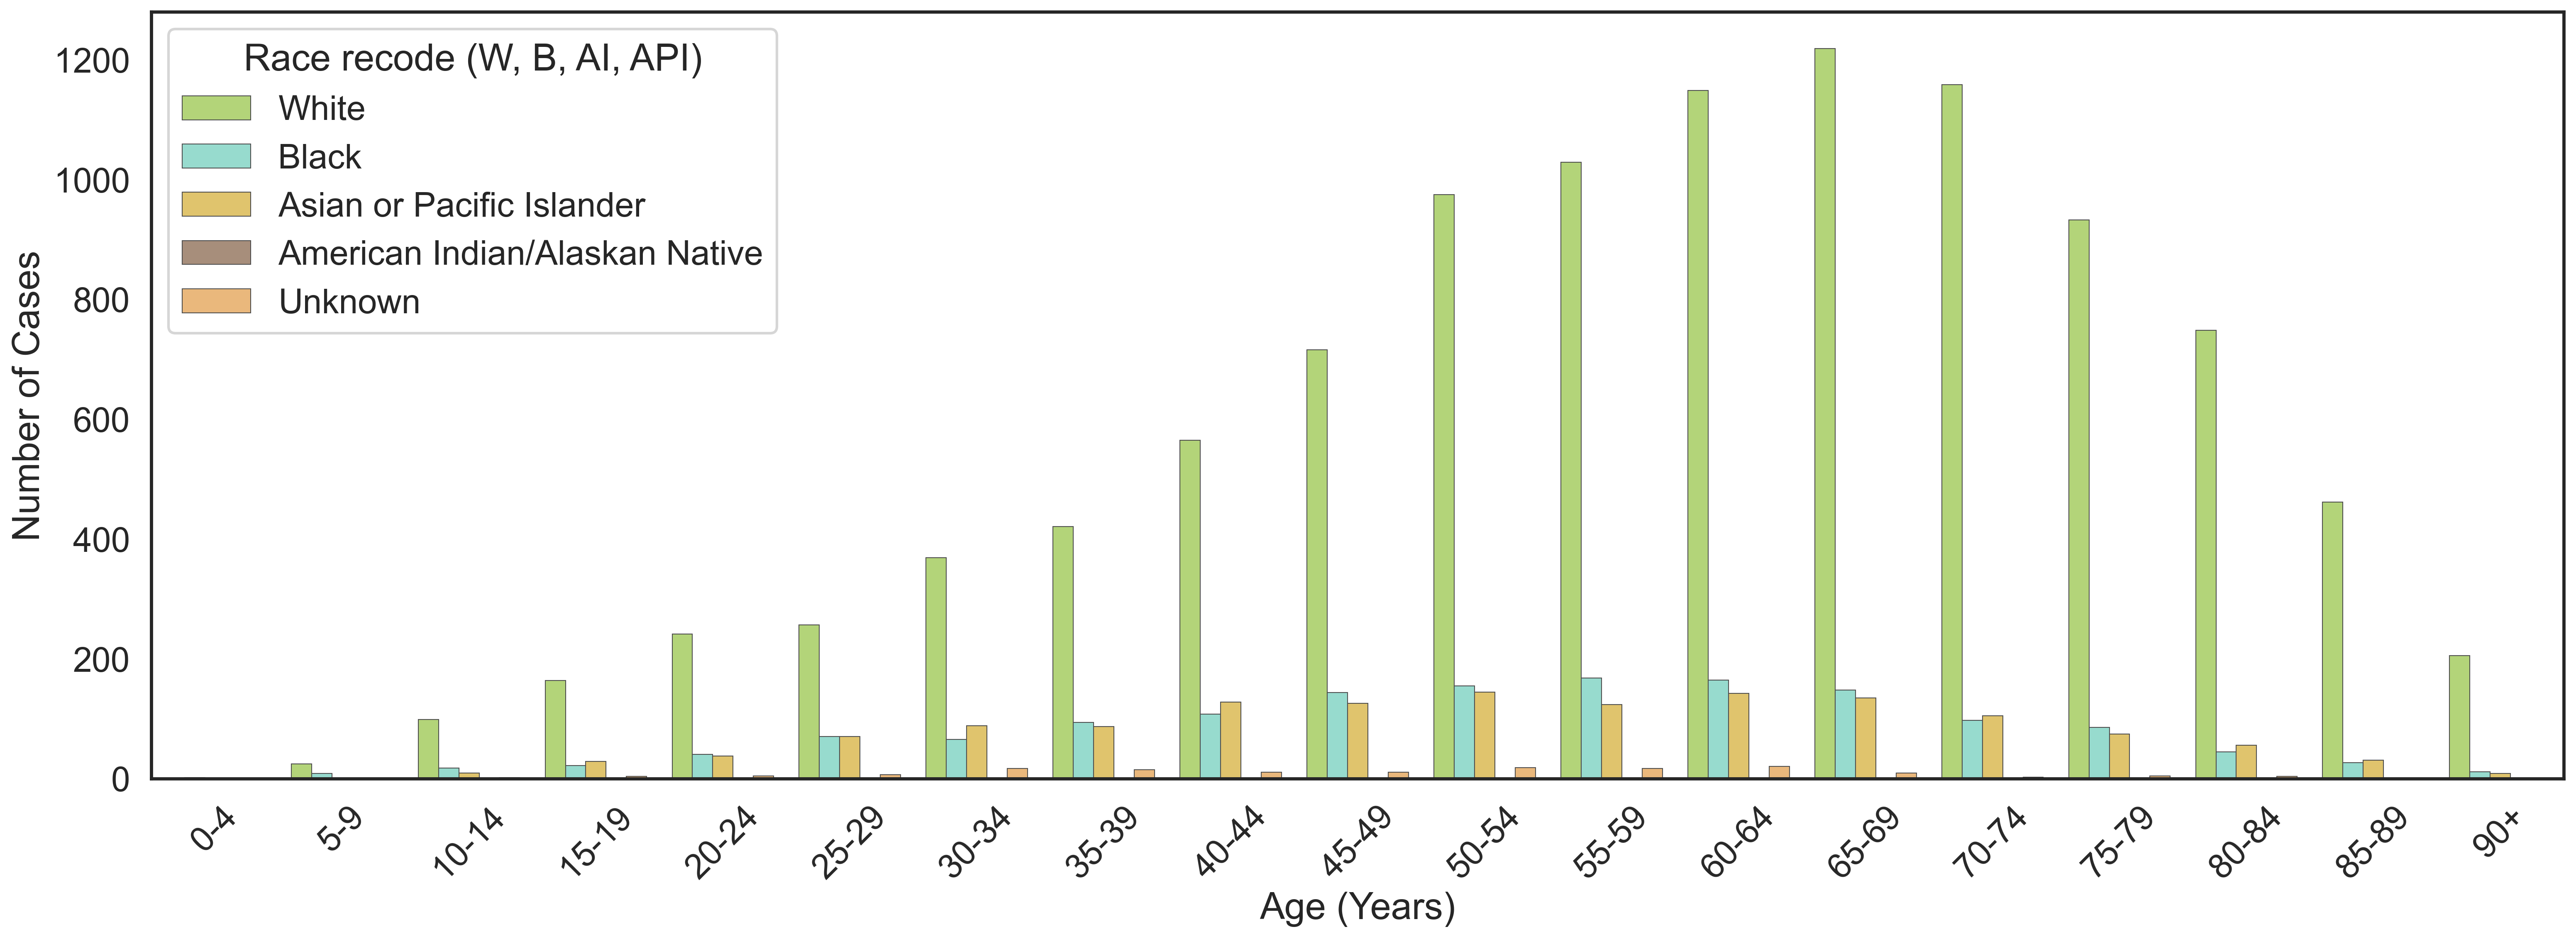

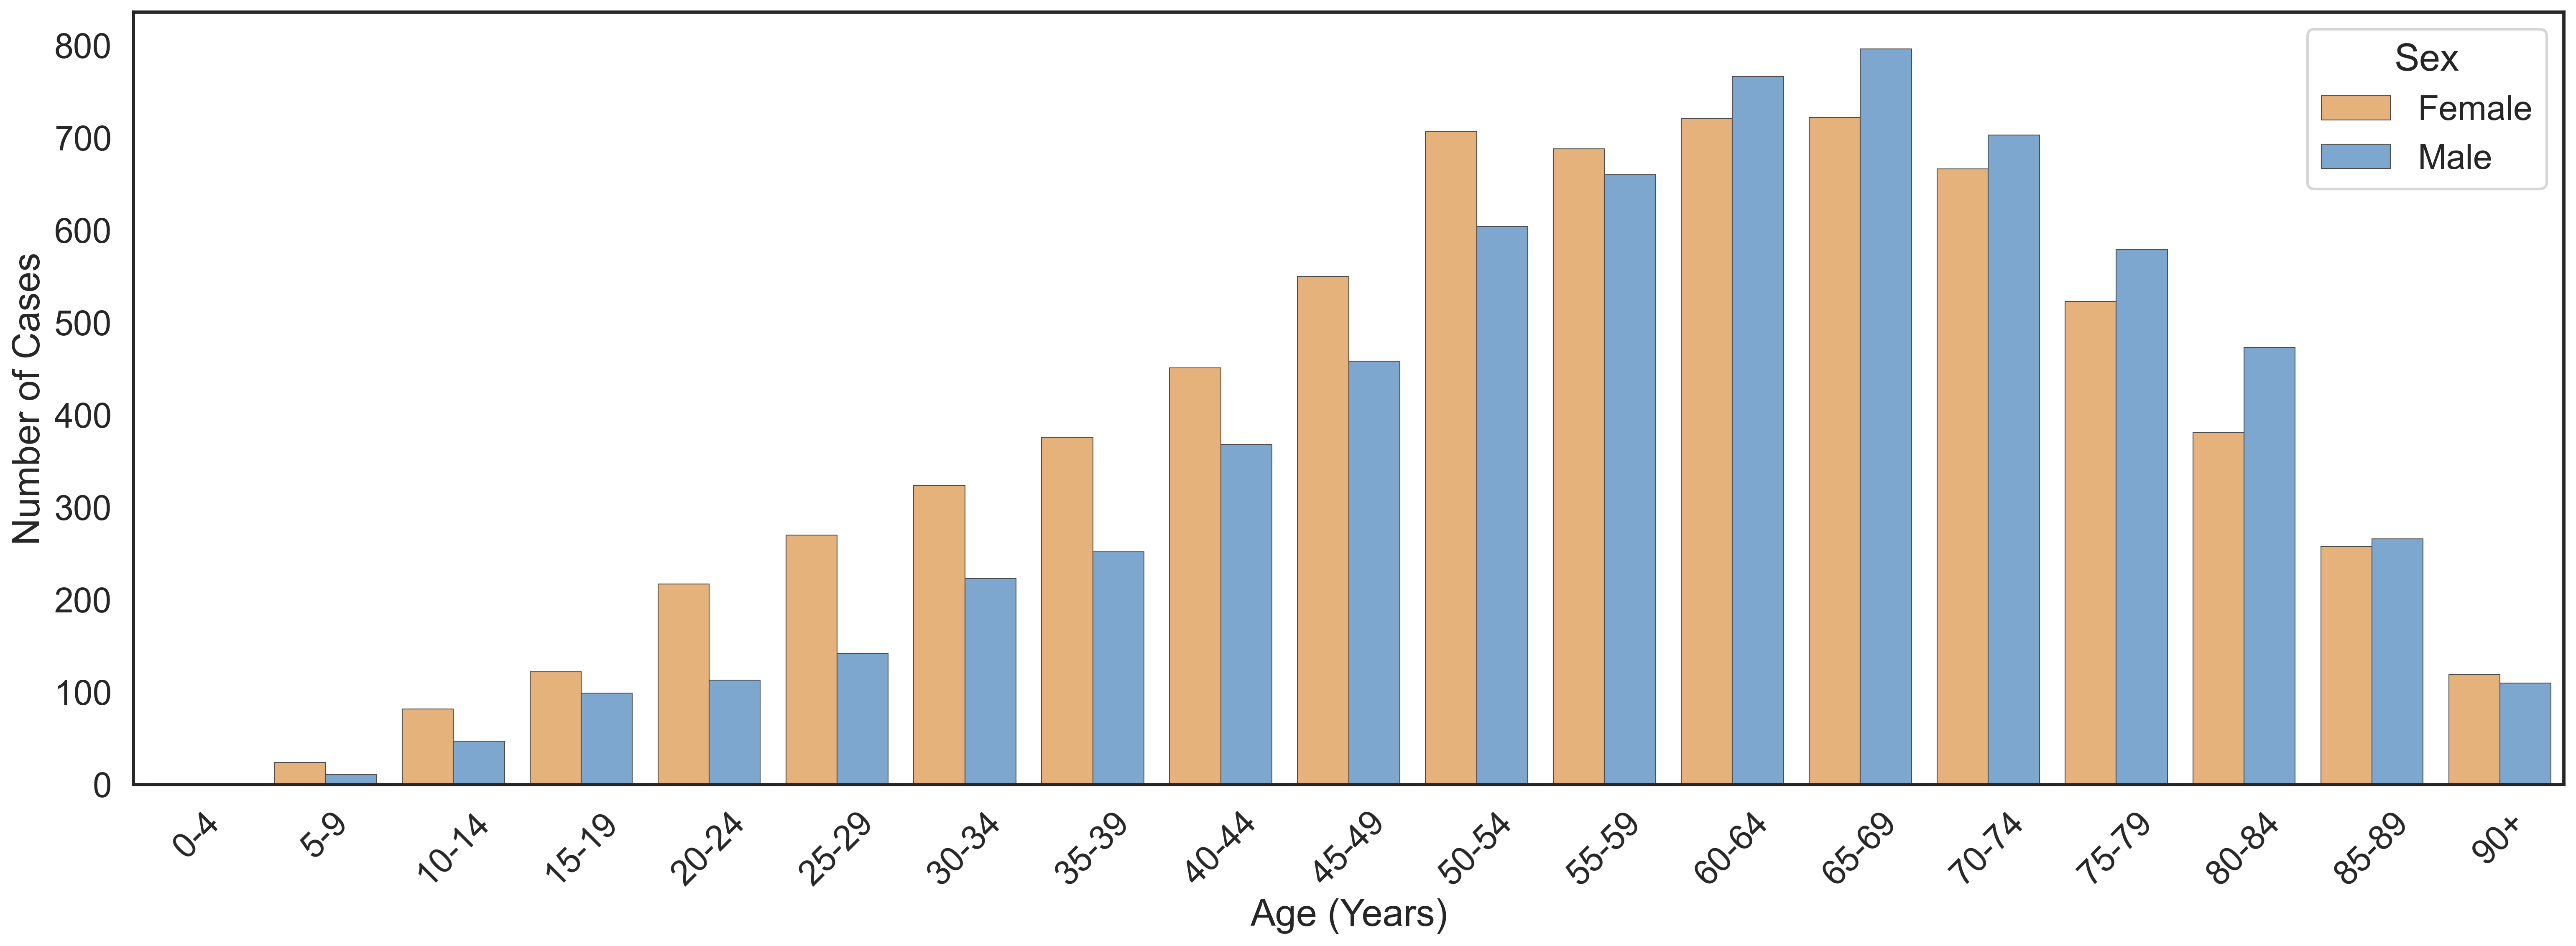

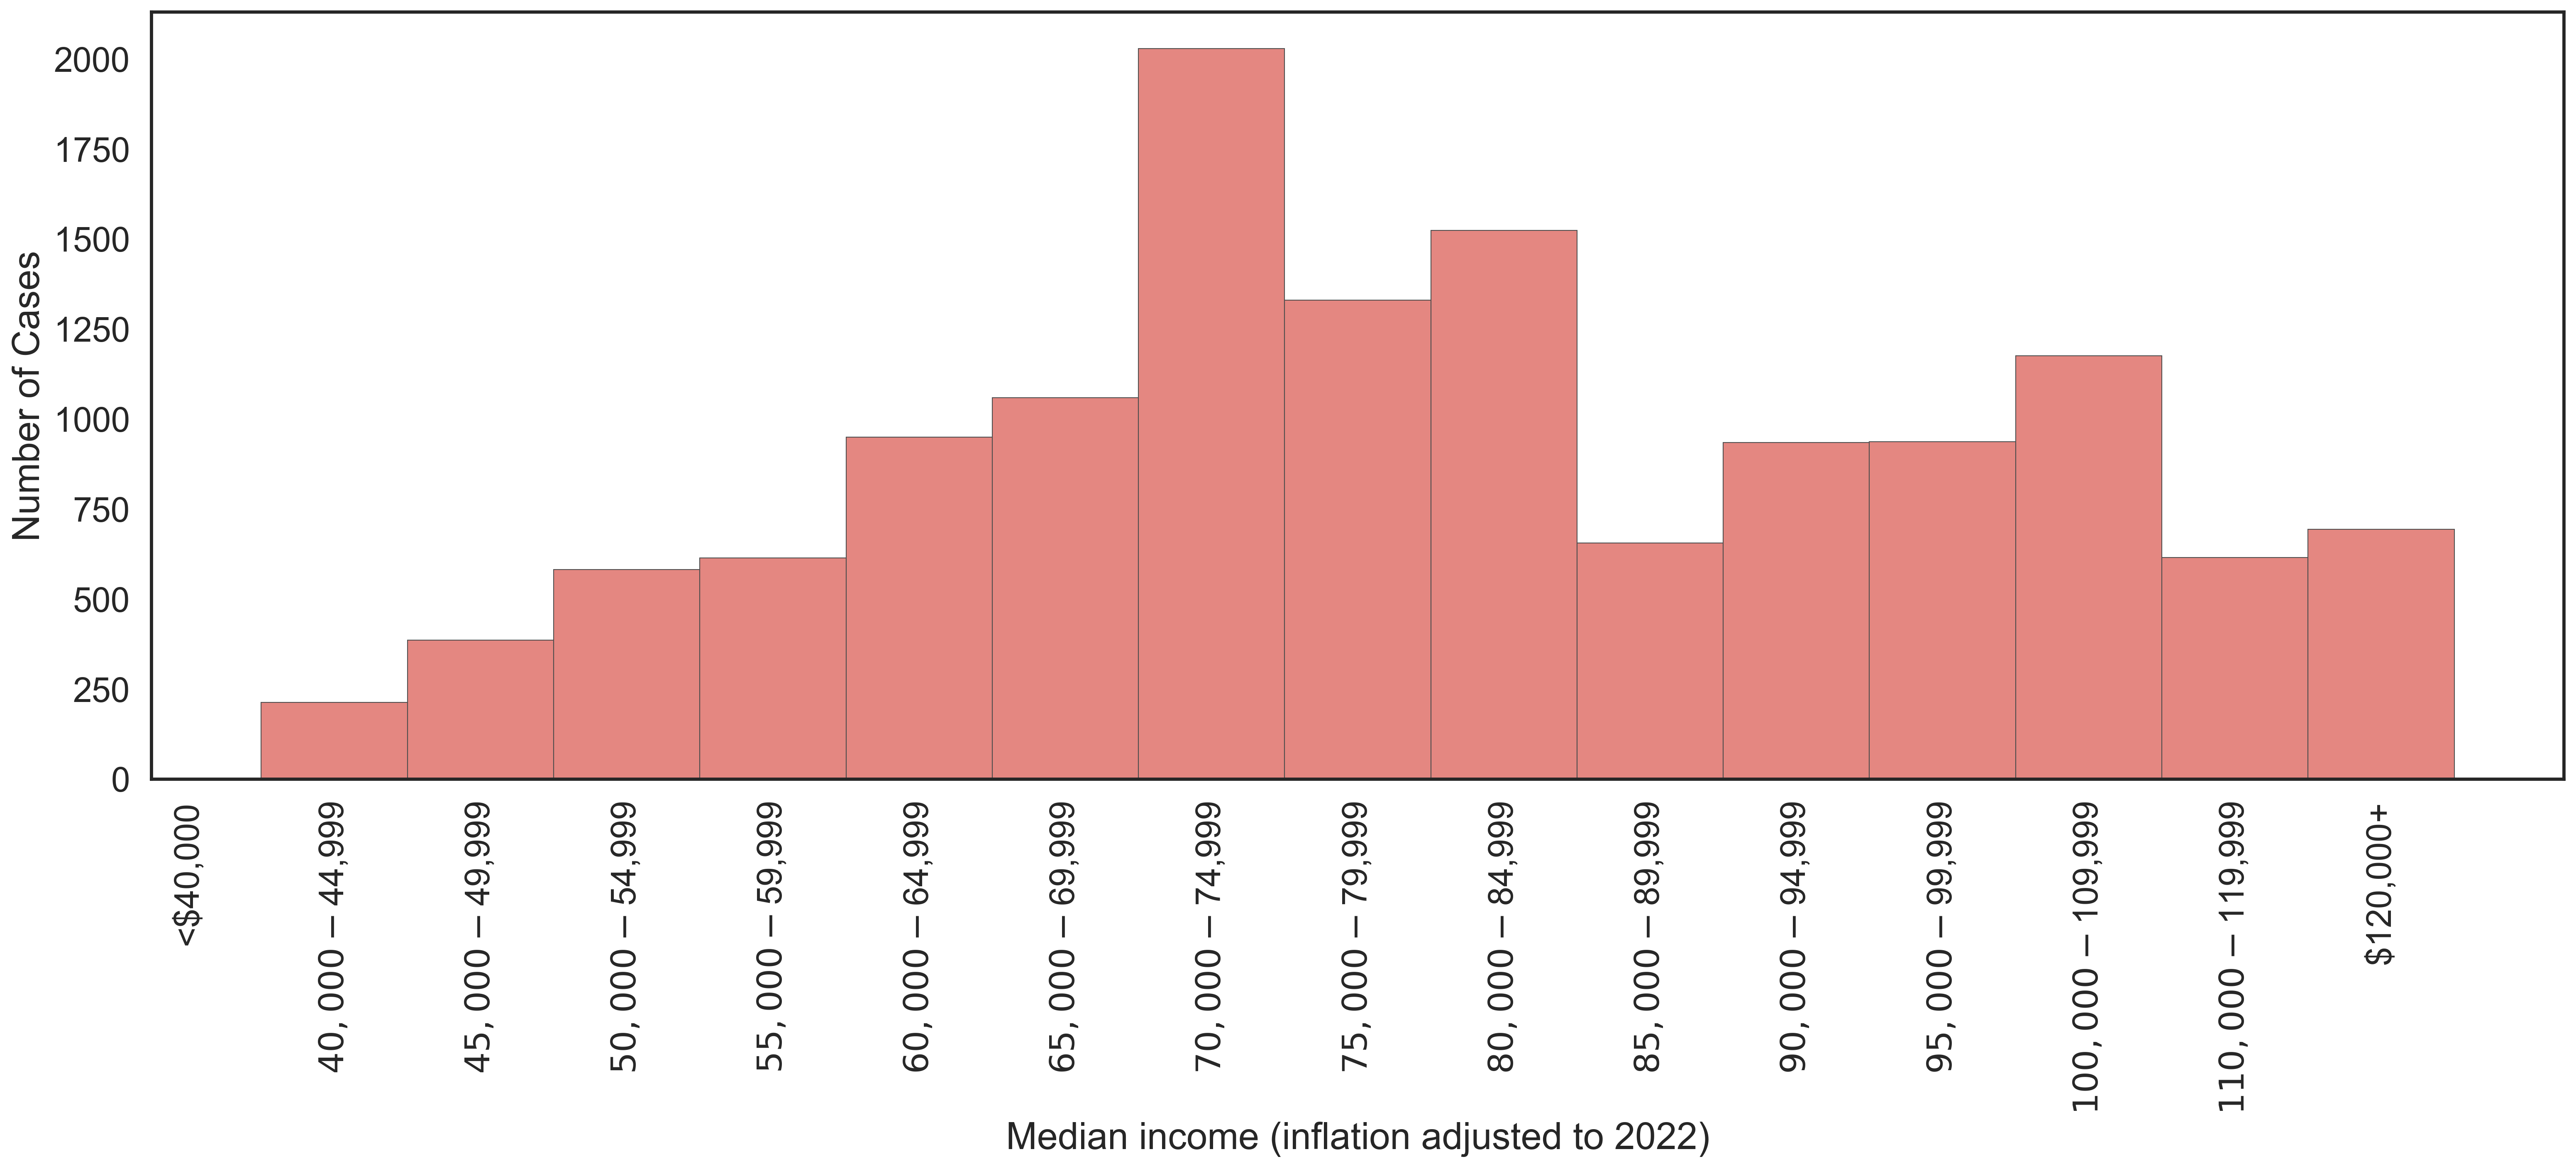

In [17]:

sns.set_style('white')
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')

# Pre-set color palettes
race_colorpalette = ['#b7e36a', '#8ce6d5', '#f3ce5a','#ae8d74','#fcb96a']
sex_colorpalette = ['#f6b26b','#6fa8dc']
ses_colorpalette = sns.color_palette(palette='gist_heat_r', n_colors=len(filtered_df[ses_colname].unique()))
marital_colorpalette = sns.color_palette(palette='inferno_r',n_colors=len(filtered_df[marital_colname].unique()))
# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=race_colname,
    palette=race_colorpalette,
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')

# Save the Race vs. Age plot
plt.savefig('race_vs_age_plot.png', dpi=300, bbox_inches='tight')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=sex_colname,
    palette=sex_colorpalette,
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

# Save the Sex vs. Age plot
plt.savefig('sex_vs_age_plot.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=filtered_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')

# Save the SES histogram
plt.savefig('ses_countplot.png', dpi=300, bbox_inches='tight')


# Socioeconomic Status Heatmap

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/957839321.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)


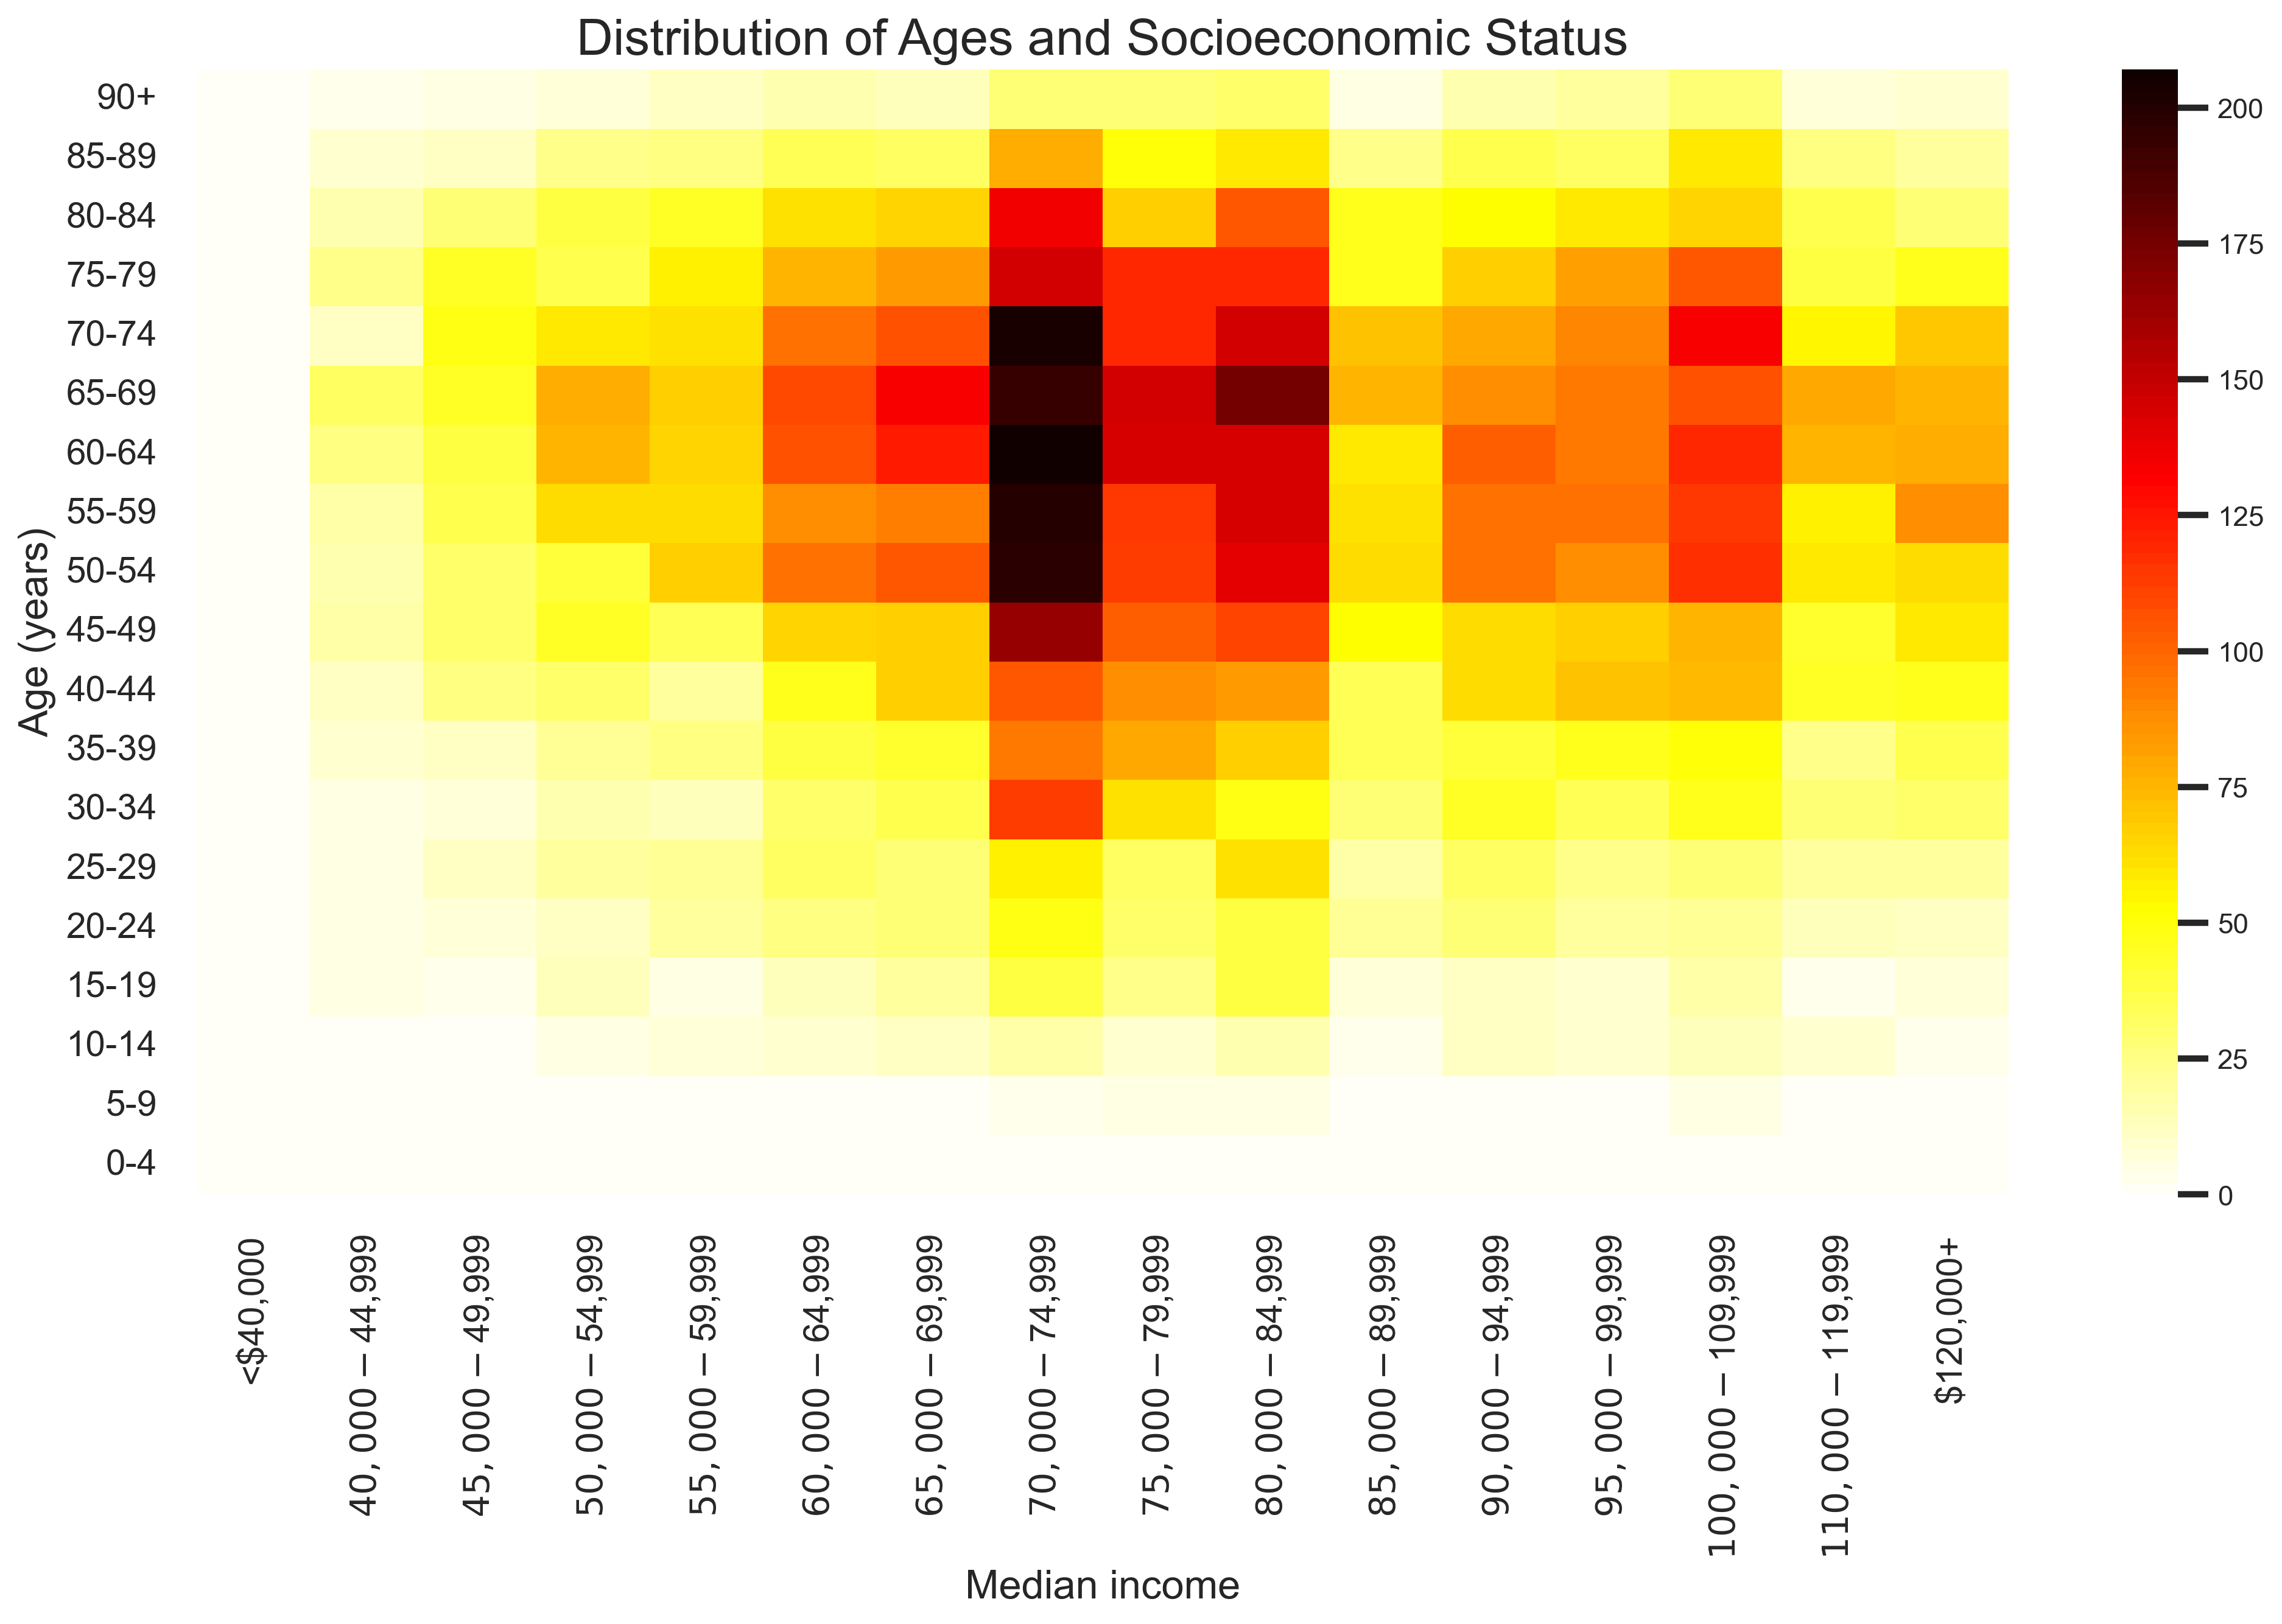

In [18]:
# Heatmap of age and socioeconomic
sns.set_context('poster',font_scale=.5)
# Create a pivot table that calculates the count of occurrences for each age and SES combination
# 
heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)

# Generate the RdYlGn palette with a specific number of colors
palette = sns.color_palette("hot_r",n_colors=100)
# Remove the darkest green, which is typically the last color in the RdYlGn palette
# You can adjust the indices depending on which colors you want to remove
# modified_palette = palette[:-1]  # This removes the last color

# Convert the modified list of colors to a colormap
cmap = sns.color_palette(palette, as_cmap=True)

# Set the figure size before creating the heatmap
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Create the heatmap
ses_heat = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt='d')
ses_heat.invert_yaxis()
title_fs = 20
plt.title('Distribution of Ages and Socioeconomic Status', fontsize=title_fs)
plt.xlabel('Median income', fontsize=title_fs*0.8)
plt.ylabel('Age (years)', fontsize=title_fs*0.8)
plt.xticks(fontsize=title_fs*0.7)
plt.yticks(fontsize=title_fs*0.7)

# Save the SES Heatmap
plt.savefig('ses_heatmap.png', dpi=300, bbox_inches='tight')


# Determine Histological Characterization + Order

In [19]:
# Histology order - Manually Defined and dependent on each dataset
histology_order = ['Adenocarcinoma','Adenoid Cystic Carcinoma','Mucoepidermoid Carcinoma','Other Rare Types','Mixed Subtypes']

# Categorize Histology column based on pre-ordained order
filtered_df['Histology'] = pd.Categorical(filtered_df['Histology'],categories=histology_order, ordered=True)

# For plotting FacetGrid determine the top N types
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order # top cancers

# Pick top N cancers for plotting
N = 3
topCancerTypes = ordered_labels[0:N]
print(topCancerTypes)
filtered_df_forFacetGrid = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]

filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()

# Color Set Up
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors

fullColorDict = dict(zip(histology_order,colors))
topNColorDict = dict(zip(topCancerTypes,colors[0:N]))

fullColorDict

['Adenocarcinoma', 'Adenoid Cystic Carcinoma', 'Mucoepidermoid Carcinoma']


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/1147726711.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()


{'Adenocarcinoma': '#FFB200',
 'Adenoid Cystic Carcinoma': '#30B7AE',
 'Mucoepidermoid Carcinoma': '#BFEF8E',
 'Other Rare Types': '#ffabab',
 'Mixed Subtypes': '#96f1ff'}

## Distribution by Age & Pie Plot

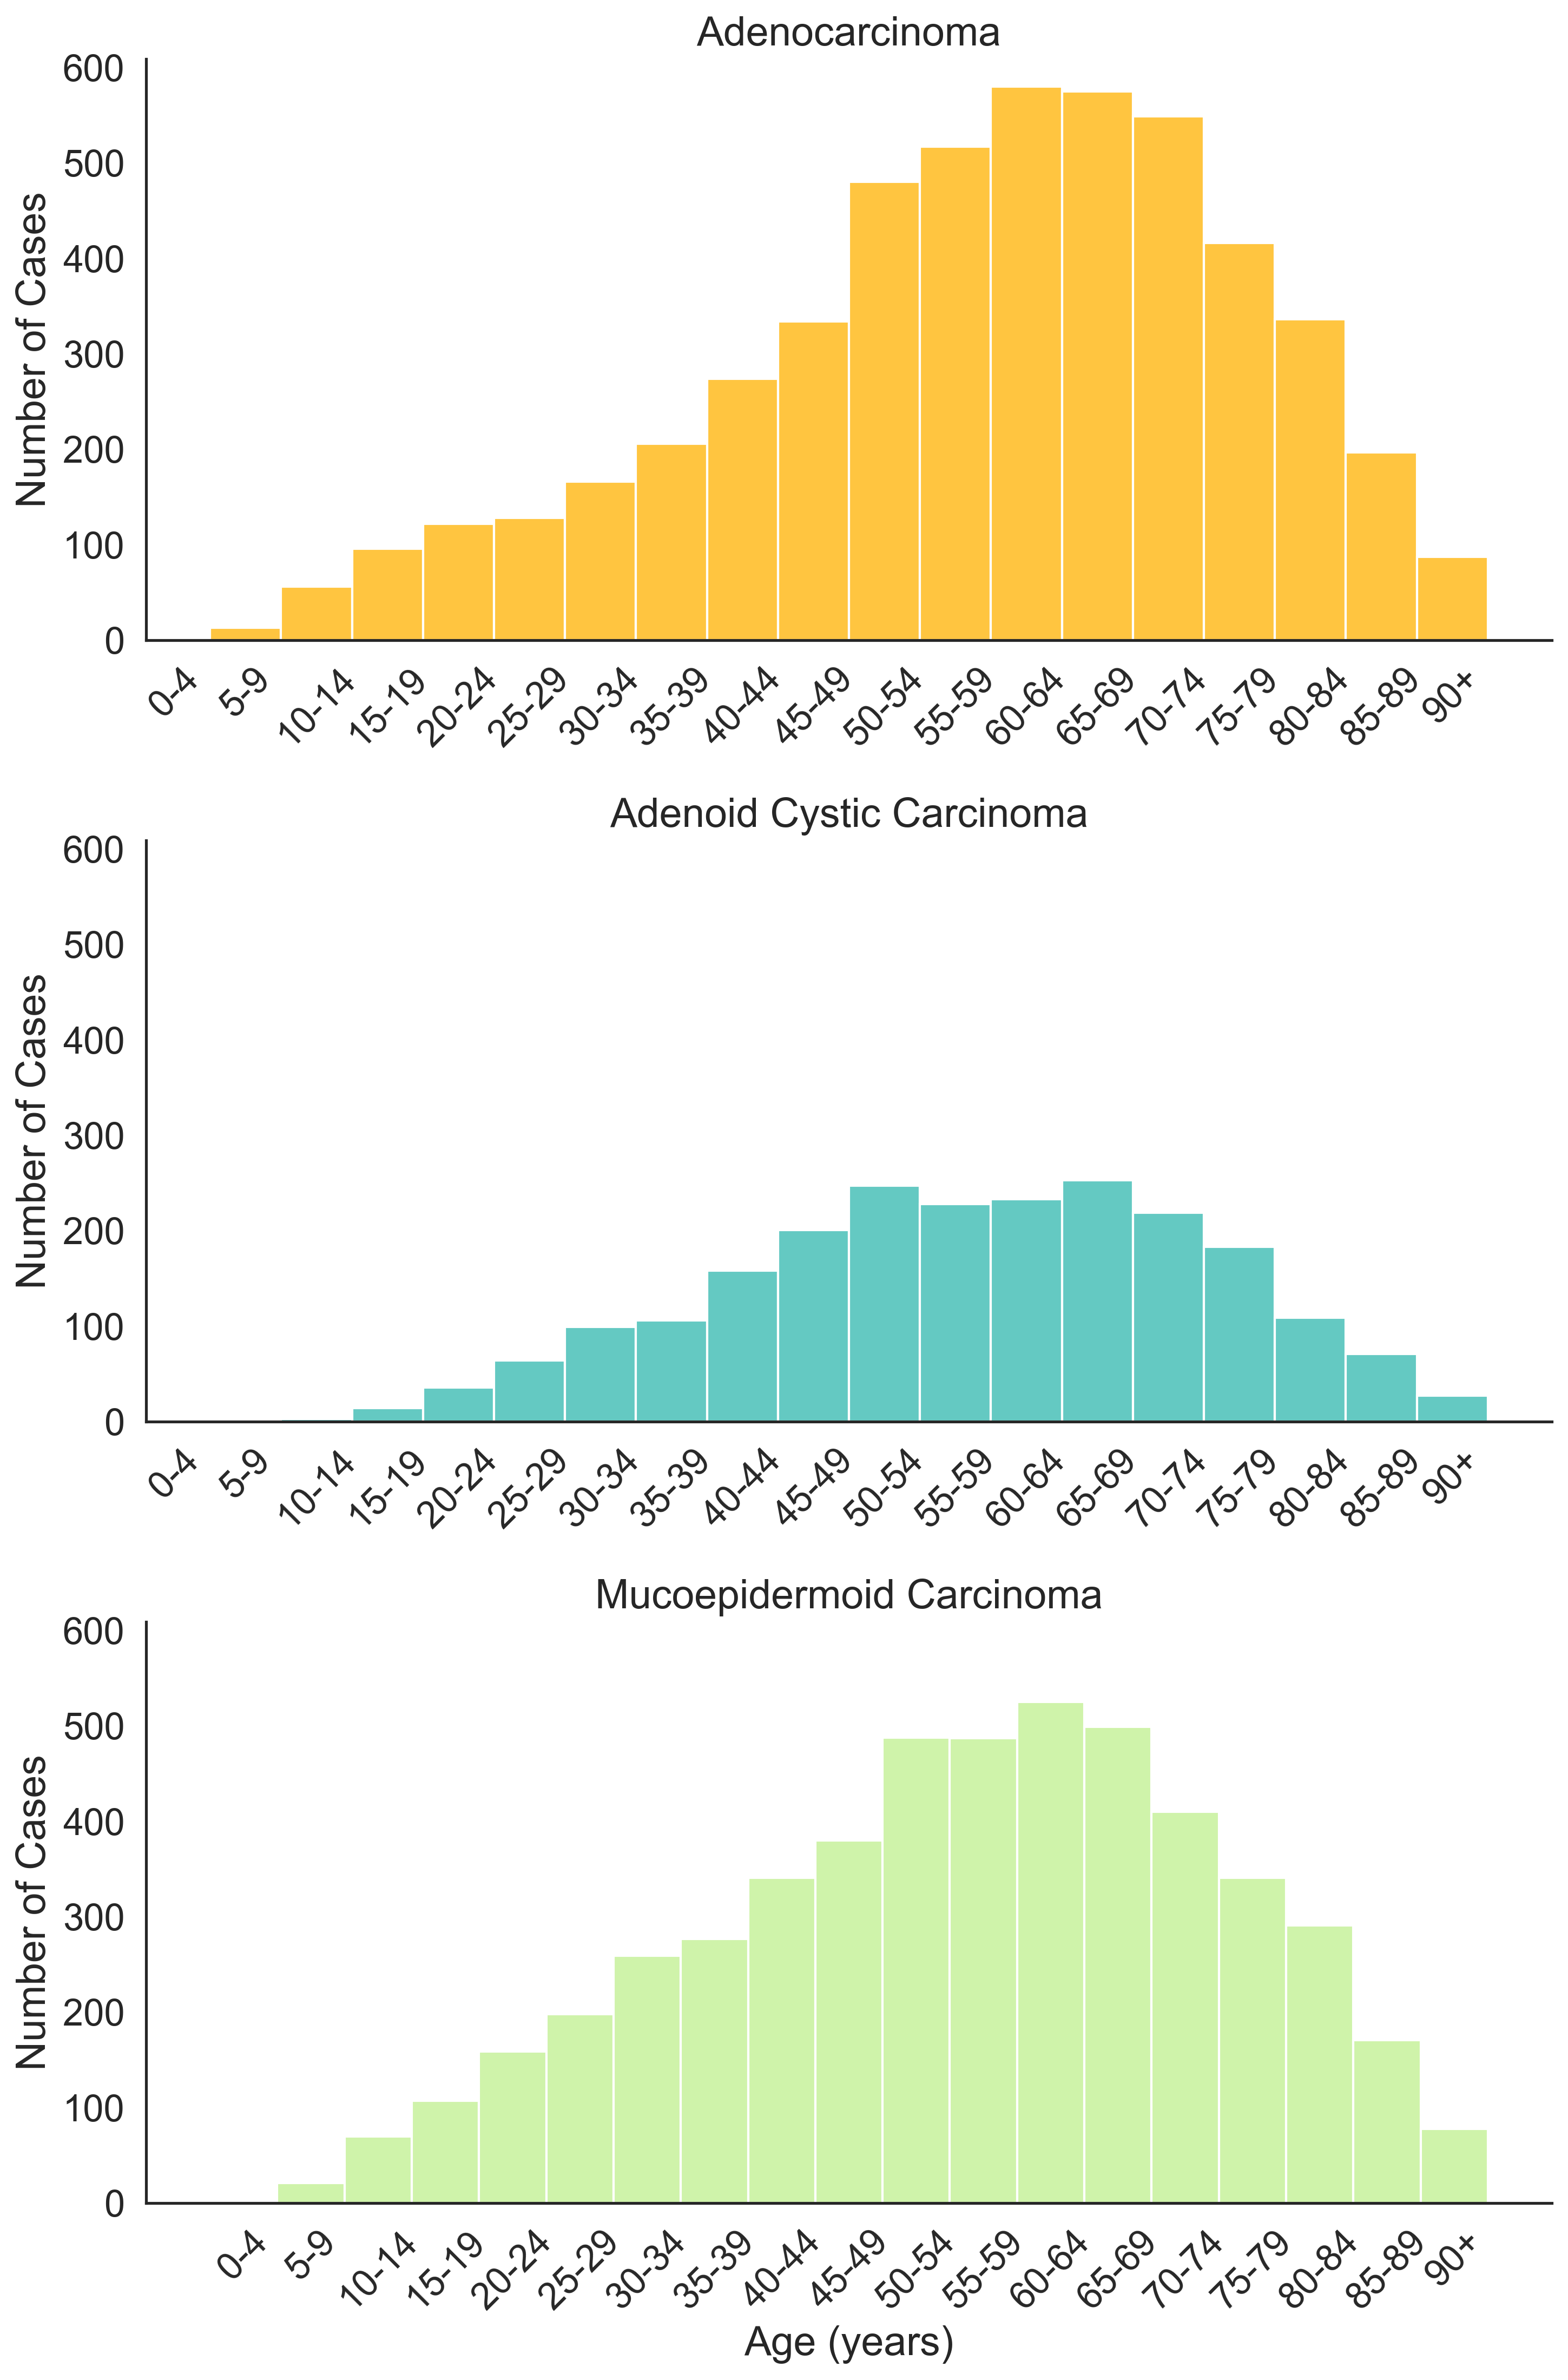

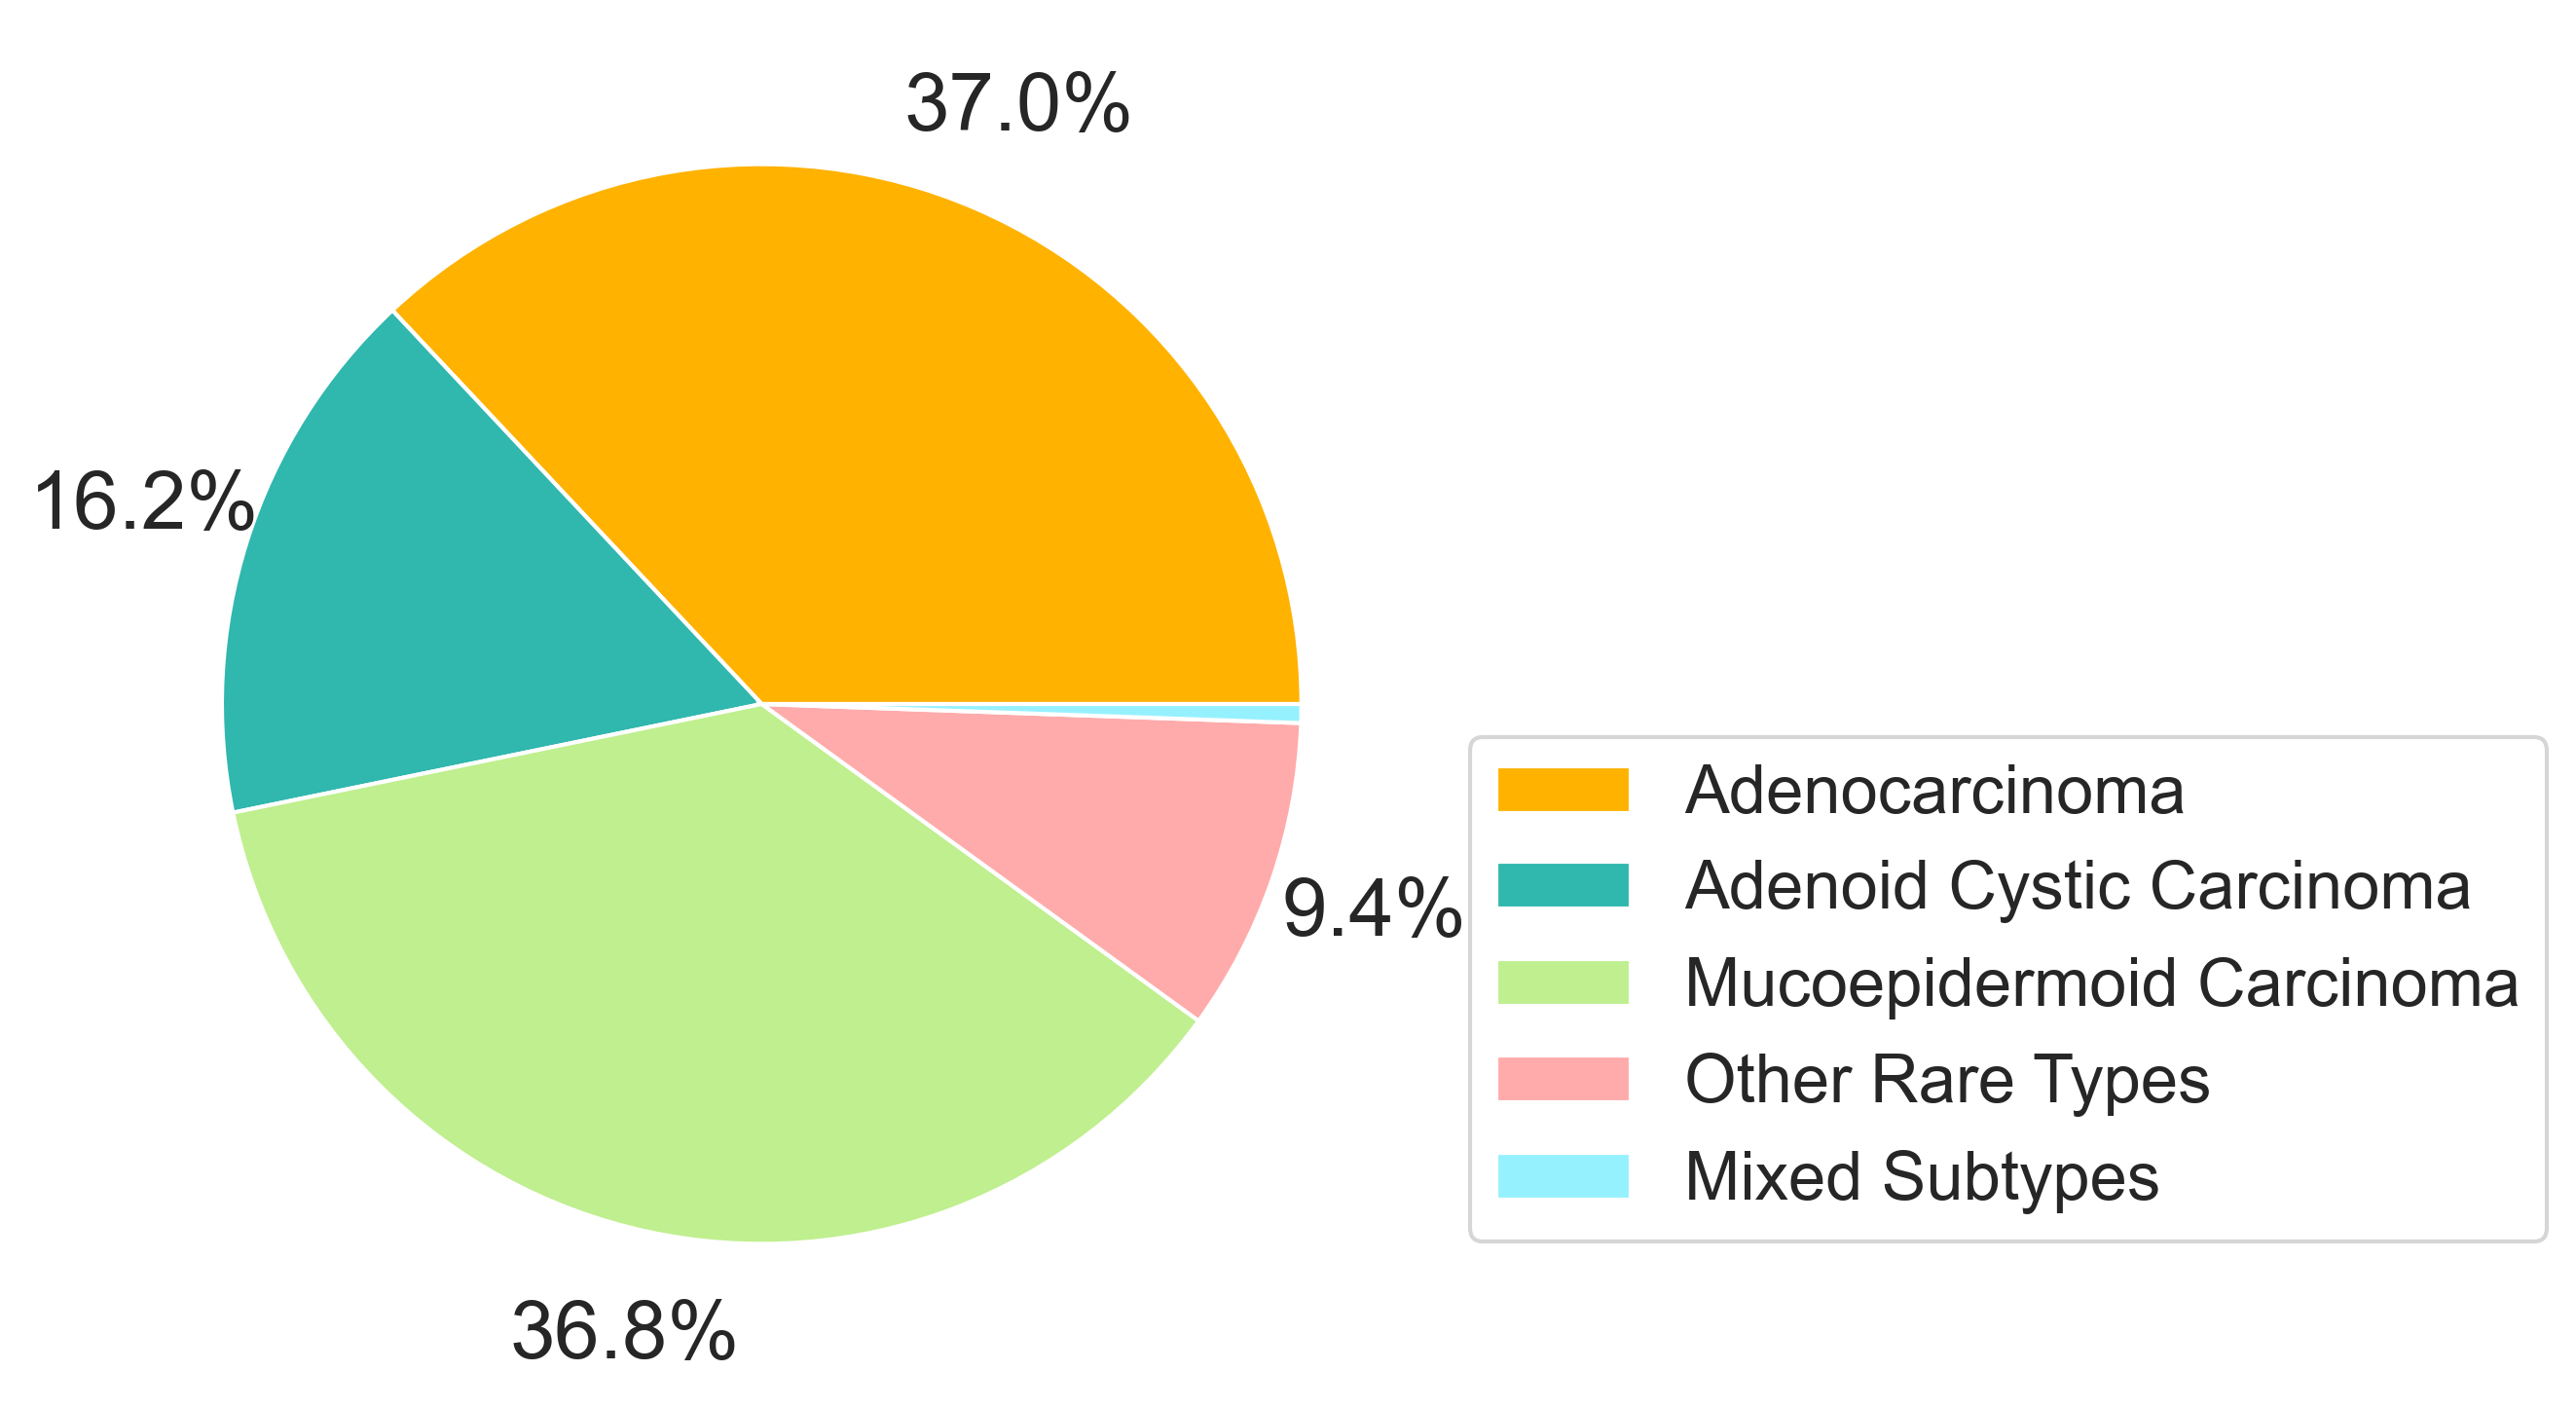

In [20]:
# Set the context for better visibility
sns.set_context("notebook", font_scale=1.5)

# Create a FacetGrid instead of using displot
g = sns.FacetGrid(filtered_df_forFacetGrid, col="Histology", col_wrap=1, height=5, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, x=age_bin_colname, binwidth=1, hue='Histology', palette=topNColorDict, multiple='stack')

# Rotate the x-tick labels in each facet
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set labels and titles
g.set_xlabels('Age (years)')
g.set_ylabels('Number of Cases')
g.set_titles(col_template="{col_name}")

# Set layout
plt.tight_layout()

# Save the Histology histograms
plt.savefig('histology_histograms.png', dpi=300, bbox_inches='tight')

plt.show()



# Calculate tumor site counts
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order

labels = tumor_type_counts.index

# Create pie chart
plt.figure(figsize=(8, 6))
# Explicit colors definition:
colors_for_pie = [fullColorDict[label] for label in ordered_labels if label in fullColorDict]
# Define a function as an input to autopct:
def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct >= 1 else ''

# Create the pie chart with specified font sizes
patches, texts, autotexts = plt.pie(
    ordered_counts, labels=None, autopct=autopct_format,
    pctdistance=1.2, colors=colors_for_pie
)

# Adjust the font size for the pie chart
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(20)

# Add legend
plt.legend(patches, ordered_labels, loc='best', bbox_to_anchor=(1, 0.5))

# Save the histology pie plot
plt.savefig('histology_pie.png', dpi=300, bbox_inches='tight')

plt.show()

## Cancer Types and Year of Diagnosis

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/143771924.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()


Year of diagnosis  Total Counts
16               2000           579
21               2001           517
19               2002           539
20               2003           518
14               2004           594
18               2005           572
13               2006           628
17               2007           573
7                2008           657
15               2009           588
12               2010           635
8                2011           655
6                2012           662
9                2013           652
11               2014           641
3                2015           695
5                2016           684
2                2017           695
0                2018           732
4                2019           691
10               2020           650
1                2021           716

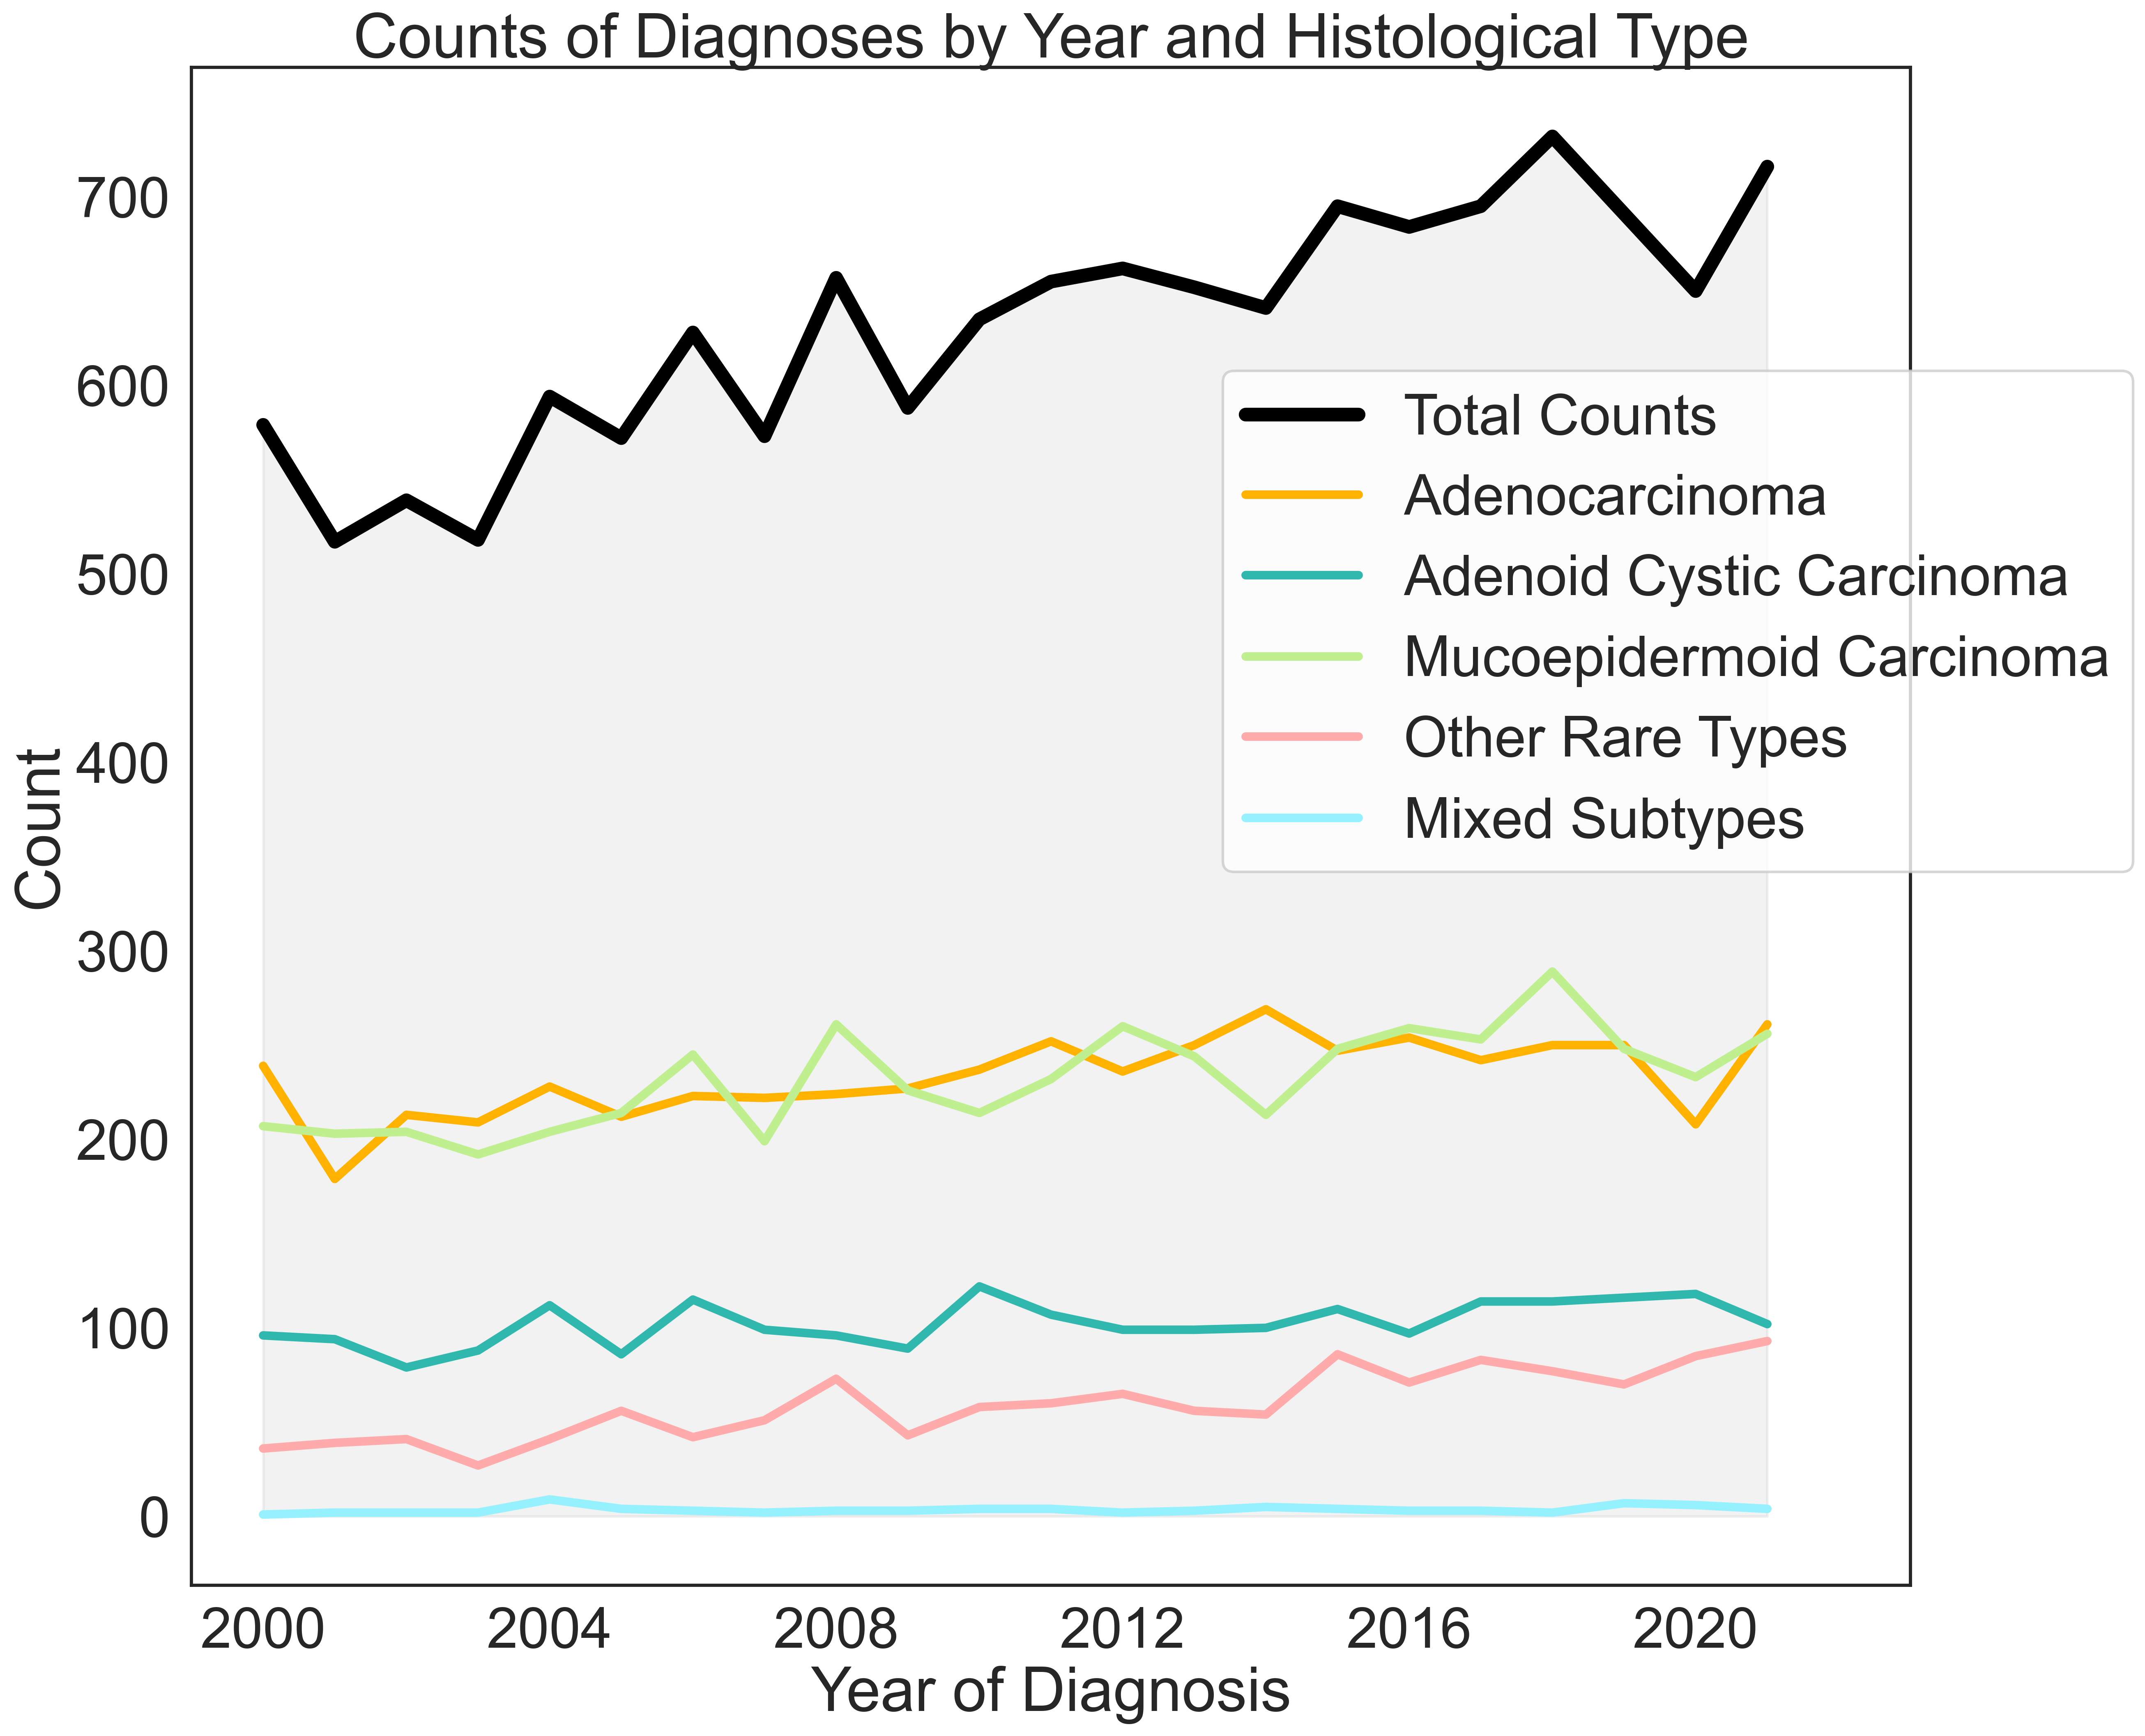

In [21]:
# Calculate counts per year per histological type.
type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()
type_year_counts_df = type_year_counts.reset_index(name='Counts')

# Calculate the counts per year for the bar plot
year_counts = filtered_df['Year of diagnosis'].value_counts()
year_counts_df = year_counts.reset_index(name='Total Counts')
year_counts_df.columns = ['Year of diagnosis', 'Total Counts']

# Ensure 'Year of diagnosis' is treated as an integer
year_counts_df['Year of diagnosis'] = year_counts_df['Year of diagnosis'].astype(int)
type_year_counts_df['Year of diagnosis'] = type_year_counts_df['Year of diagnosis'].astype(int)

# Sort both dataframes by 'Year of diagnosis' to ensure proper plotting order
year_counts_df = year_counts_df.sort_values('Year of diagnosis')
type_year_counts_df = type_year_counts_df.sort_values('Year of diagnosis')

# Display for verification
display(year_counts_df)

# Create plot and aesthetics
plt.figure(figsize=(18,16))
sns.set_context('talk', font_scale=2)

# Create the bar plot in the background for total counts per year
# sns.lineplot(year_counts_df,x='Year of diagnosis',y='Total Counts',
#              color=(0,0,0),lw=8,zorder=1,label='Total Count')
# Create the line plot for total counts per year
# We're using plt.plot instead of sns.lineplot to have more control over shading
plt.plot(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
         color='black', label='Total Counts', lw=8)

# Fill the area under the line with a shaded color
plt.fill_between(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
                 color='grey', alpha=0.1)

# Create line plot for each individual histological type
sns.lineplot(type_year_counts_df,x='Year of diagnosis',y='Counts',
             palette=colors,hue='Histology',lw=5,zorder=2)

# Adjust the x value limits
plt.xlim(1999,2023)
plt.xticks(range(2000,2022,4))
plt.grid(False, axis='y')
# Adjust legend position and add 'Total Counts' to the legend
plt.legend(bbox_to_anchor=(.6, .8), loc='upper left', borderaxespad=0.)

# Add labels and title
plt.xlabel('Year of Diagnosis')
plt.ylabel('Count')
plt.title('Counts of Diagnoses by Year and Histological Type')

plt.savefig('counts_vs_year.png', dpi=300, bbox_inches='tight')
plt.show()

# Age, Race, and Sex Proportions & Distributions

## Generate Excel files

In [36]:
# Calculate counts (value_counts with normalized=False) and sort (sort_index())
colsForTables = [age_bin_colname,sex_colname,race_colname,ses_colname,'Income_quartile',marital_colname,site_colname,'Grade Label','Grade Level']
# Create an Excel writer object and specify the file path
output_file_path = 'merged_tables.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for col in colsForTables:
        counts = (filtered_df[col].
                  value_counts(normalize=False).
                  sort_index())

        # Calculate proportions (normalized=True), sort (sort_index()), convert to indices
        proportions = (filtered_df[col].
                       value_counts(normalize=True).
                       sort_index())

        # Merge the counts and proportions into one table
        merged_table = pd.DataFrame({'Counts': counts, 'Proportions': proportions})
        print(merged_table)
        # Write each DataFrame to a different sheet
        merged_table.to_excel(writer, sheet_name=col[:30])

        # Create a pivot table for counts
        counts_table = filtered_df.pivot_table(
            index=col,      # Rows (e.g., Age)
            columns='Histology',        # Columns (e.g., Histology categories)
            aggfunc='size',            # Aggregation function (count in this case)
            fill_value=0                # Fill missing values with 0
        )

        counts_table.to_excel(writer, sheet_name=col[:20]+'_wide')

    
print(f"Merged tables exported to {output_file_path}")

            Counts  Proportions
Age_Binned                     
0-4              2     0.000144
5-9             35     0.002523
10-14          129     0.009299
15-19          221     0.015930
20-24          330     0.023787
25-29          412     0.029698
30-34          547     0.039429
35-39          628     0.045268
40-44          819     0.059036
45-49         1008     0.072659
50-54         1311     0.094500
55-59         1348     0.097167
60-64         1487     0.107187
65-69         1518     0.109421
70-74         1369     0.098681
75-79         1102     0.079435
80-84          854     0.061558
85-89          524     0.037771
90+            229     0.016507
        Counts  Proportions
Sex                        
Female    7202     0.519138
Male      6671     0.480862
                                Counts  Proportions
Race recode (W, B, AI, API)                        
White                            10739     0.779714
Black                             1479     0.107384
Asian or

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/995036149.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/995036149.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/995036149.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var

# Survival Analysis

### Data Preparation and Clinical Column Identification

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/709769579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


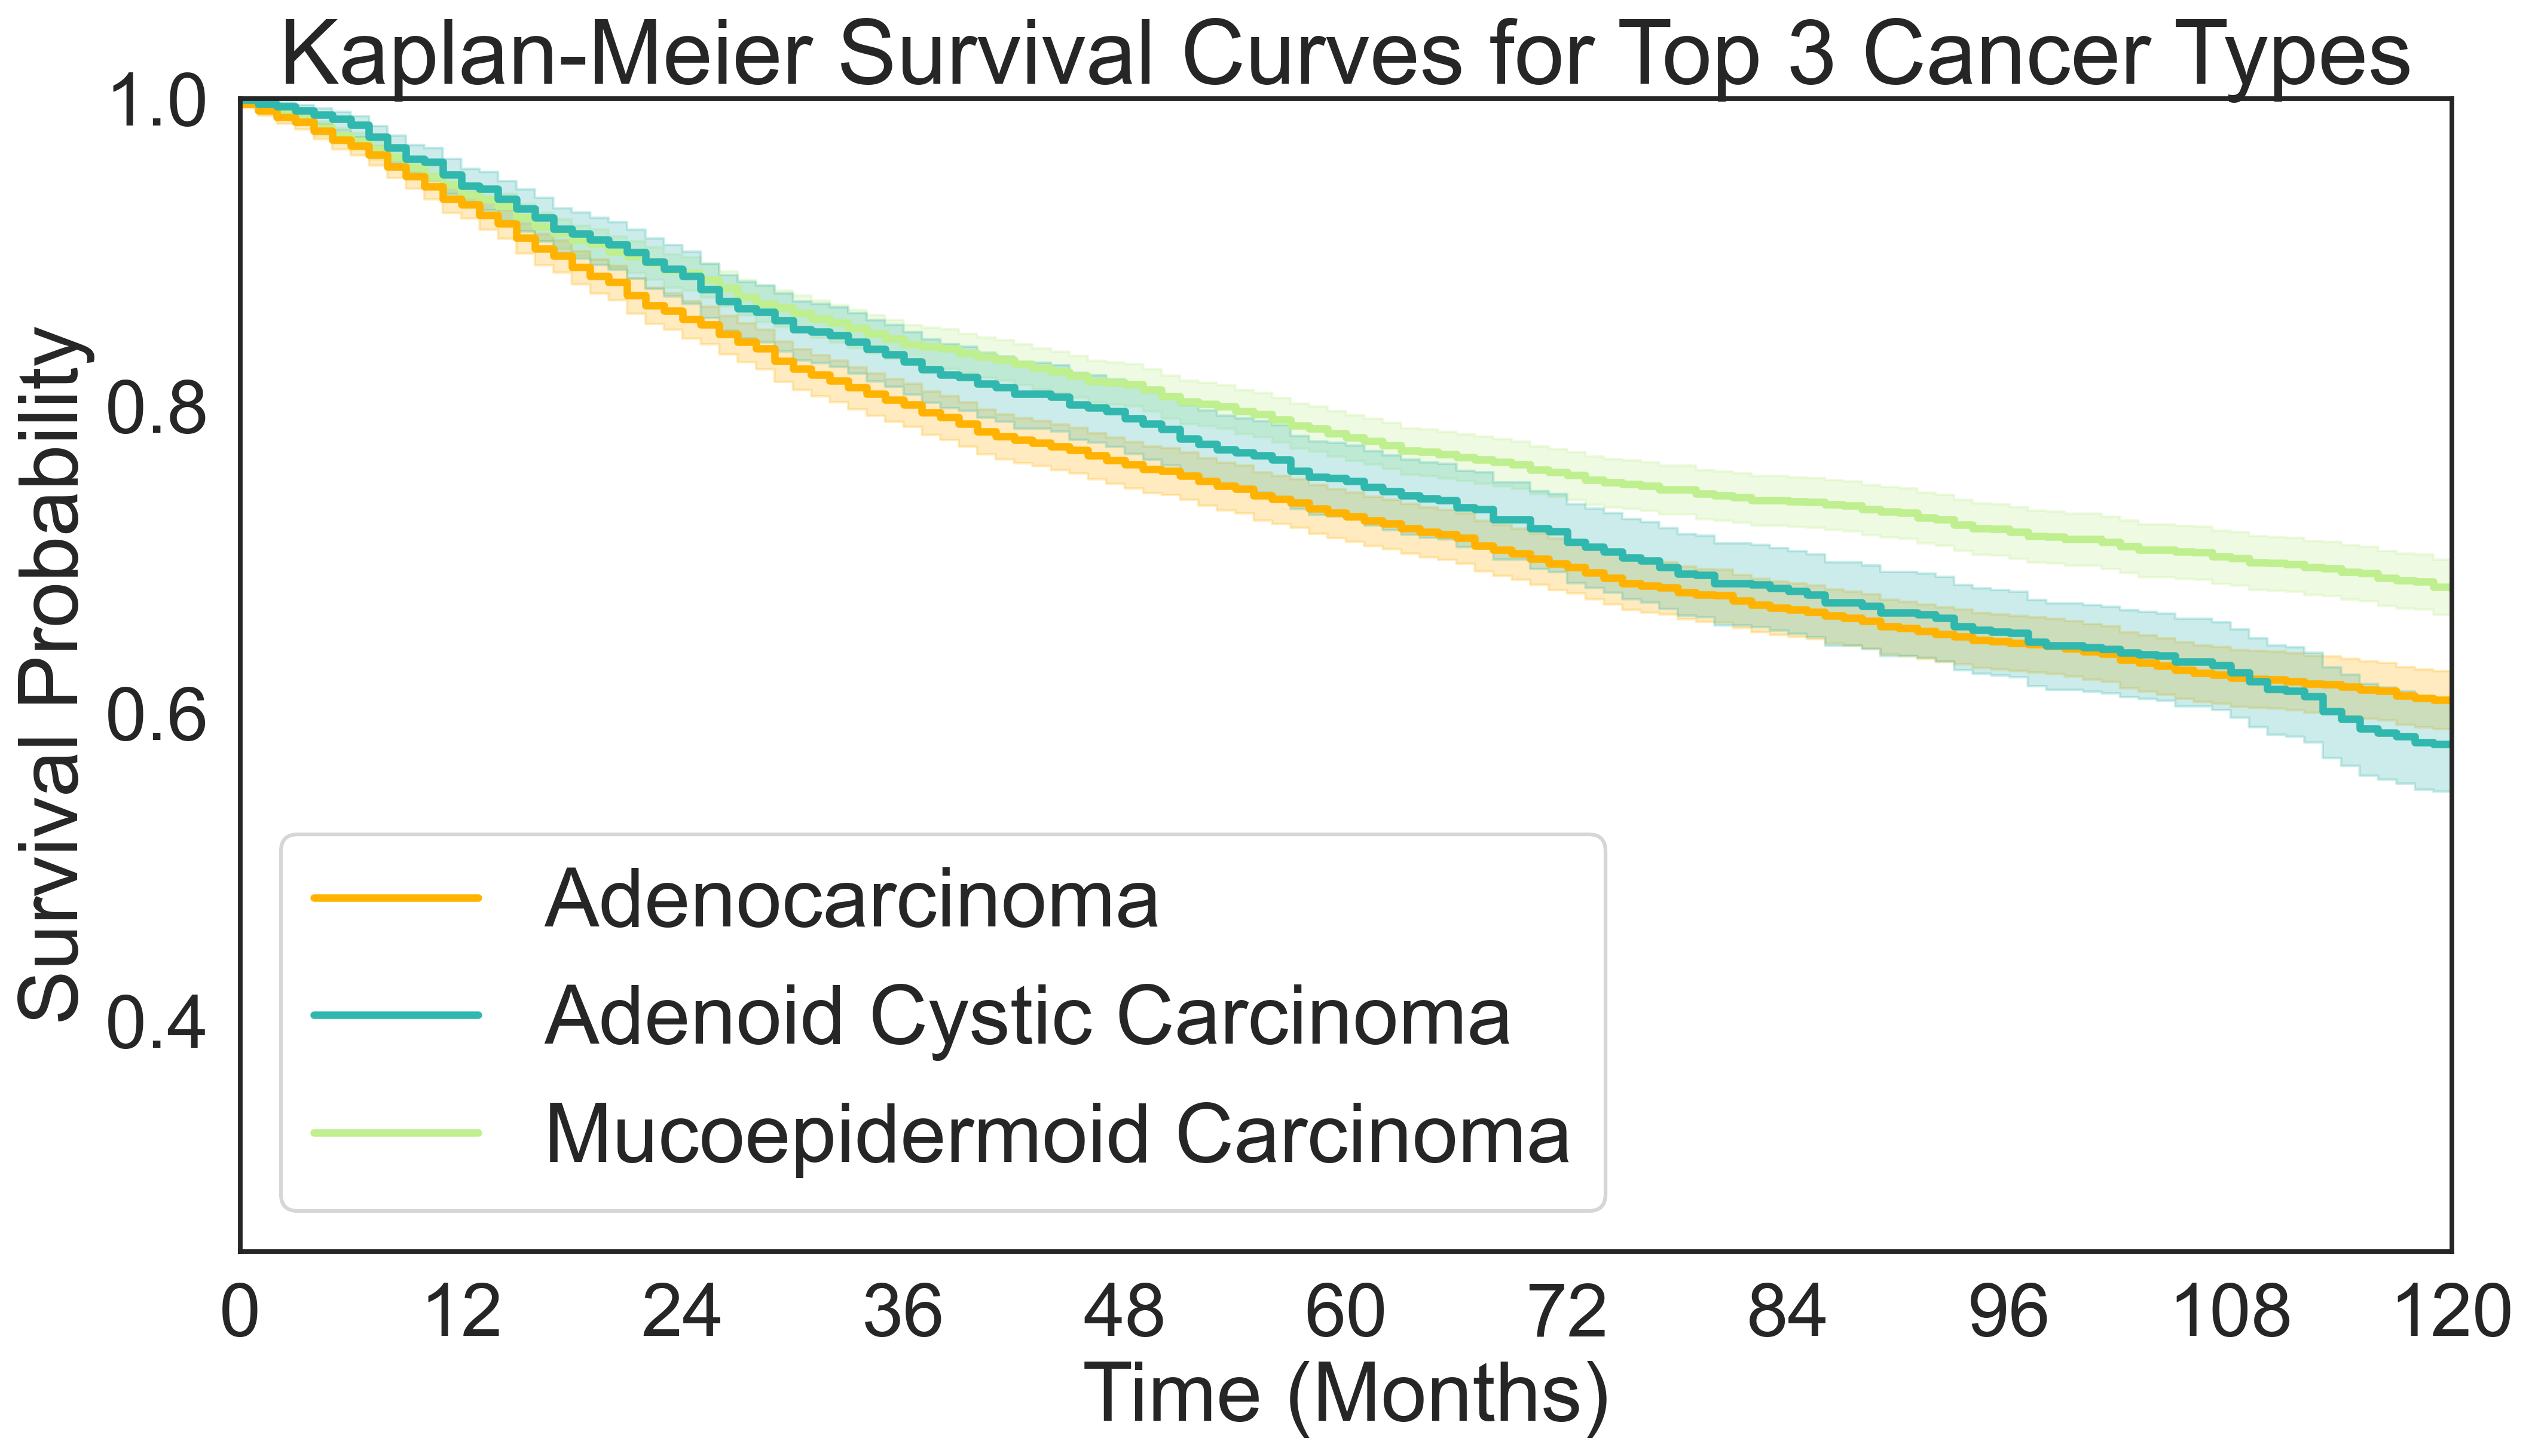

In [37]:
# Select relevant columns for clinical characteristics analysis
clinical_columns = ['Primary Site - labeled', 'Histologic Type ICD-O-3',
                     'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
                     'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Grade Label', 'Laterality',
                     'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
                     'ICD-O-3 Hist/behav, malignant','Histology','ICD-O-3 Code','SEER cause-specific death classification',
                    'SEER other cause of death classification', 'Survival months',
                    'Survival months flag', 'COD to site rec KM',
                    'COD to site recode ICD-O-3 2023 Revision',
                    'COD to site recode ICD-O-3 2023 Revision Expanded (1999+)',
                    'Vital status recode (study cutoff used)', 'Sequence number',
                    'First malignant primary indicator', 'Primary by international rules']

# Creating a summary for clinical characteristics
clinical_summary = filtered_df[clinical_columns]

# Display the summary
# display(clinical_summary)

vital_percentages = clinical_summary["Vital status recode (study cutoff used)"].value_counts(normalize=True) * 100
alive_percentage = vital_percentages["Alive"]
dead_percentage = vital_percentages["Dead"]

print(vital_percentages)

## Kaplan Meier Survival Curves:
## Histology Based KMs

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_84721/1050420270.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


<class 'pandas.core.frame.DataFrame'>
Index: 8366 entries, 6 to 28015
Data columns (total 73 columns):
 #   Column                                                     Non-Null Count  Dtype   
---  ------                                                     --------------  -----   
 0   Patient ID                                                 8366 non-null   int64   
 1   Age recode with <1 year olds                               8366 non-null   object  
 2   Sex                                                        8366 non-null   category
 3   Year of diagnosis                                          8366 non-null   int64   
 4   PRCDA 2020                                                 8366 non-null   object  
 5   Race recode (W, B, AI, API)                                8366 non-null   category
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    8366 non-null   object  
 7   Site recode ICD-O-3/WHO 2008                               8366 non-null   object  
 8   Be

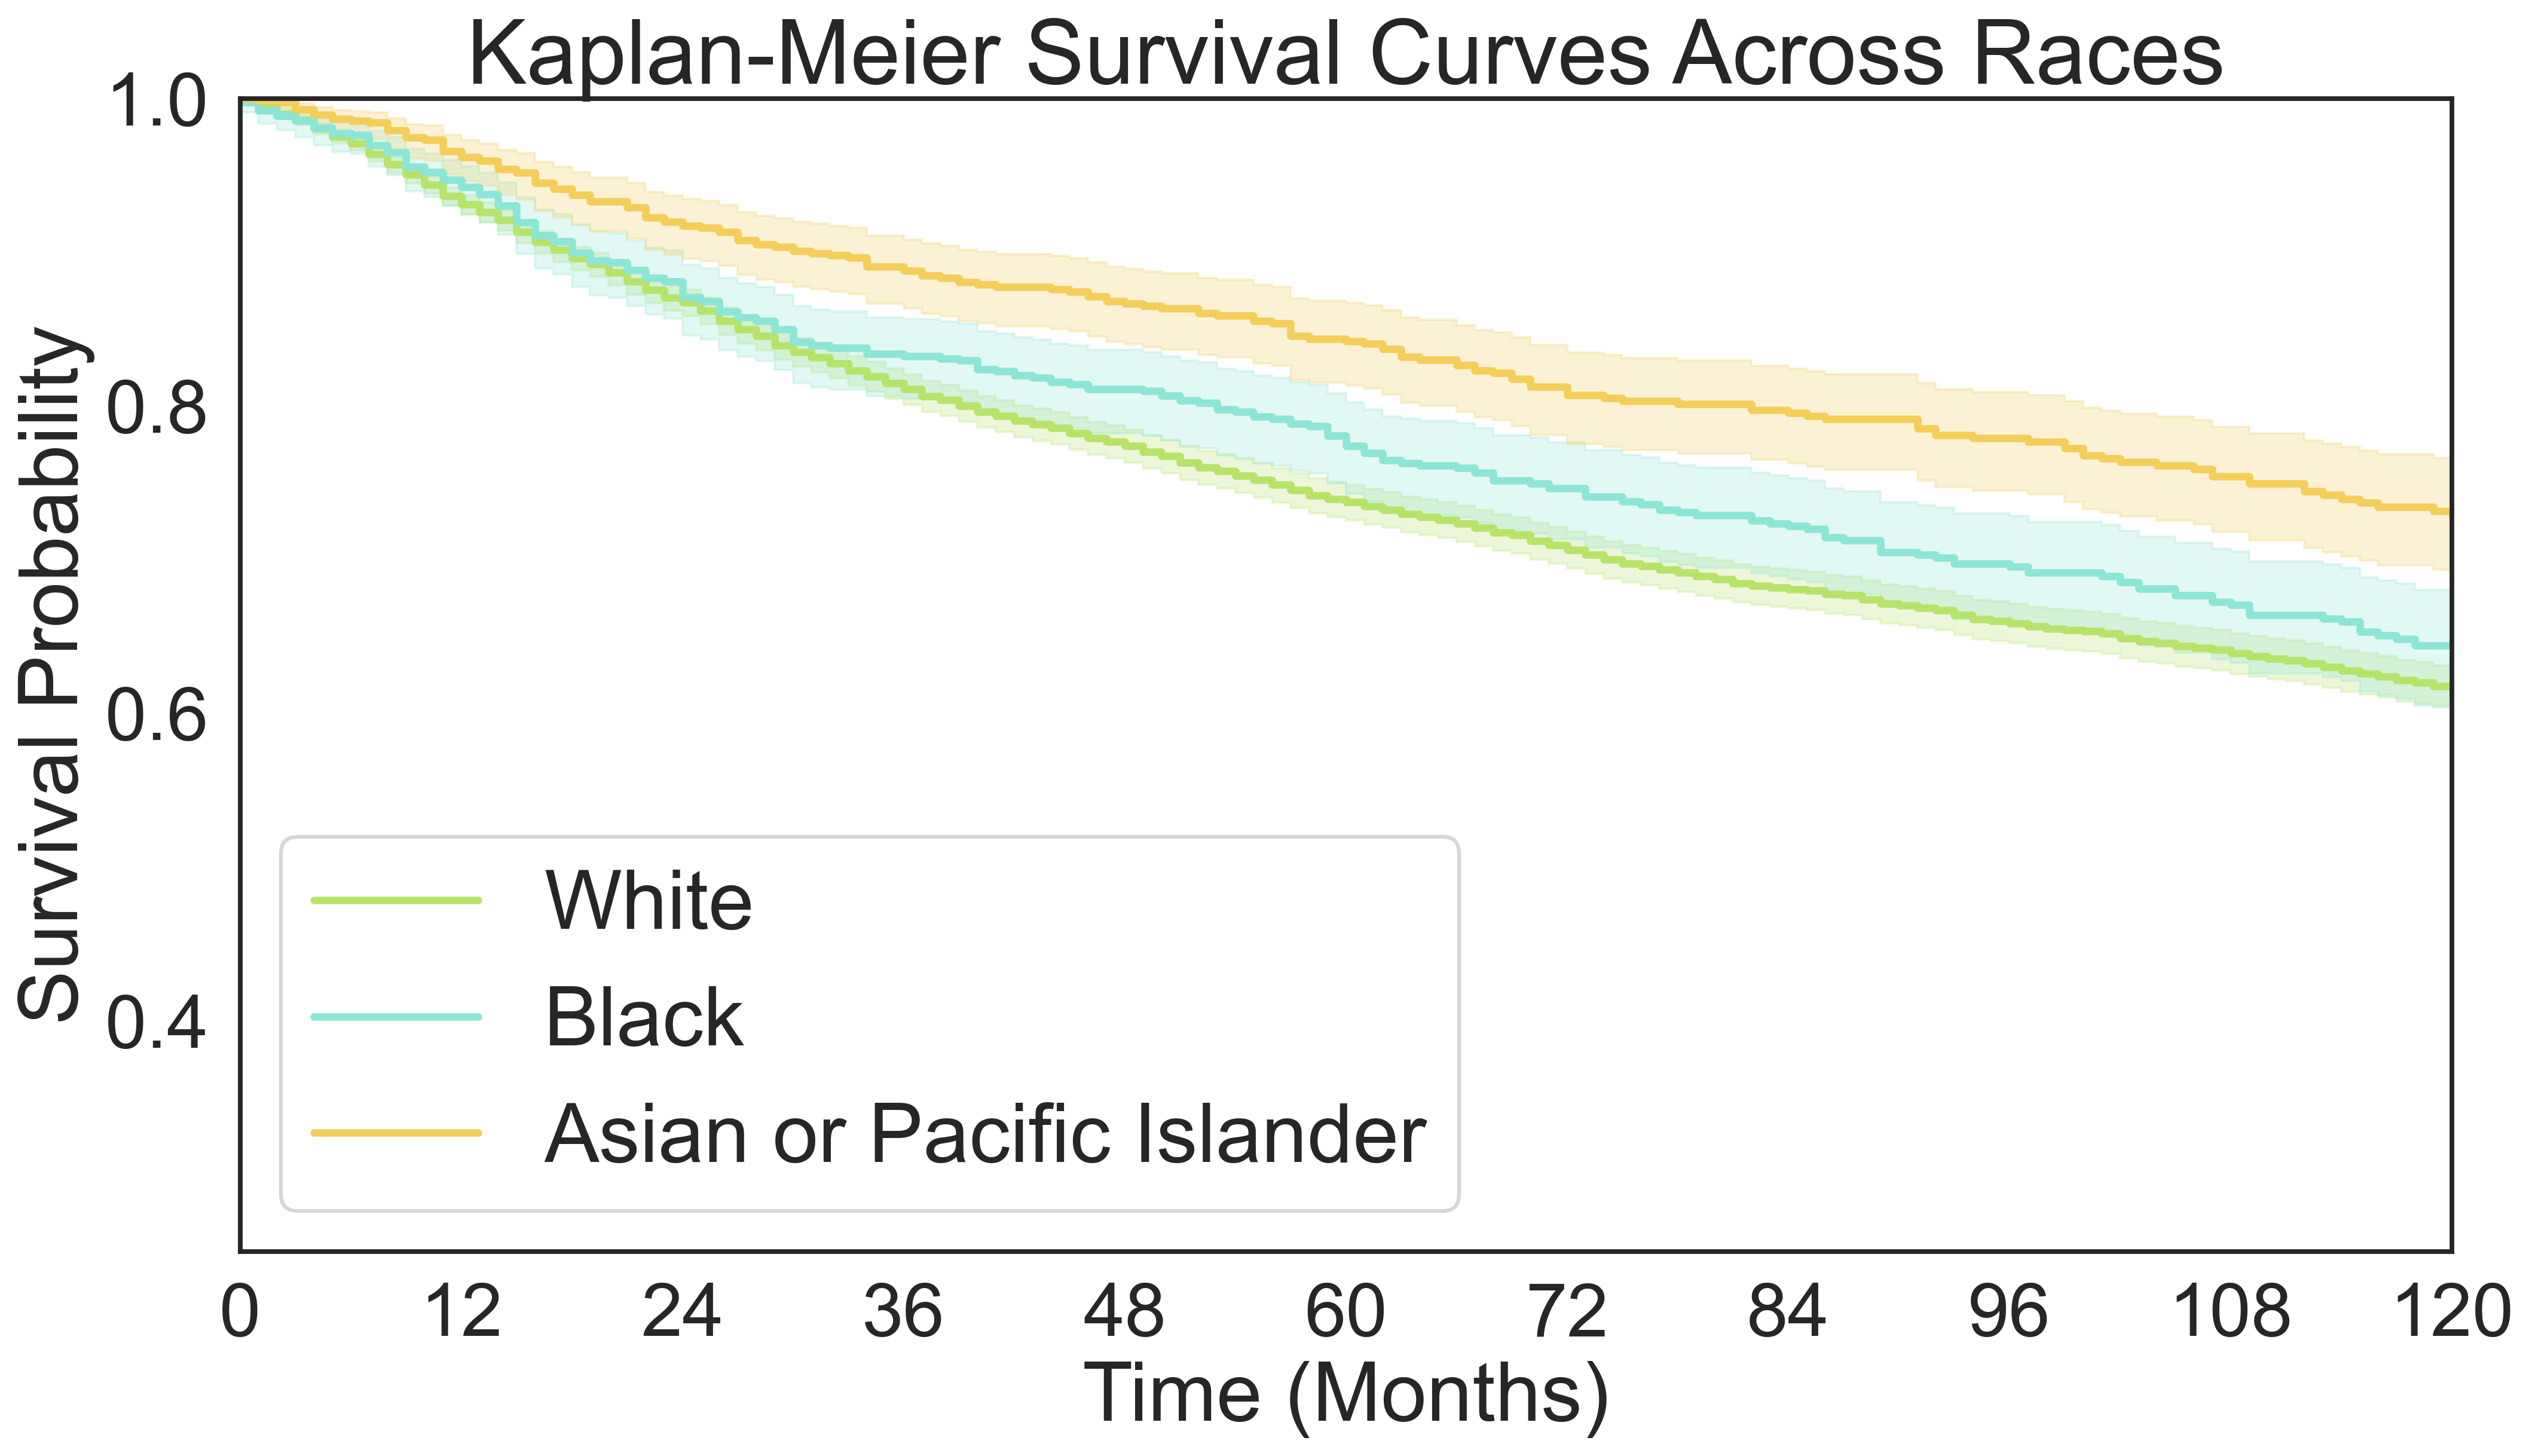

In [38]:
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
# else 2 if x == 'Dead (missing/unknown COD)'
else 0)

# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique cancer types in your dataset
cancer_types = df['Histology'].unique()

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for cancer_type in cancer_types:
    # Filter the DataFrame for each cancer type
    df_cancer = df[df['Histology'] == cancer_type]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_cancer['Survival months'], event_observed=df_cancer['event_occurred'], label=cancer_type)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=topNColorDict[cancer_type])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Top 3 Cancer Types', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = topCancerTypes

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Race Based KMs

6        Upper middle quartile
9             Highest quartile
10            Highest quartile
16       Upper middle quartile
17       Upper middle quartile
                 ...          
28000          Lowest quartile
28005          Lowest quartile
28009    Lower middle quartile
28014    Lower middle quartile
28015    Lower middle quartile
Name: Income_quartile, Length: 8285, dtype: category
Categories (4, object): ['Highest quartile' < 'Upper middle quartile' < 'Lower middle quartile' < 'Lowest quartile']


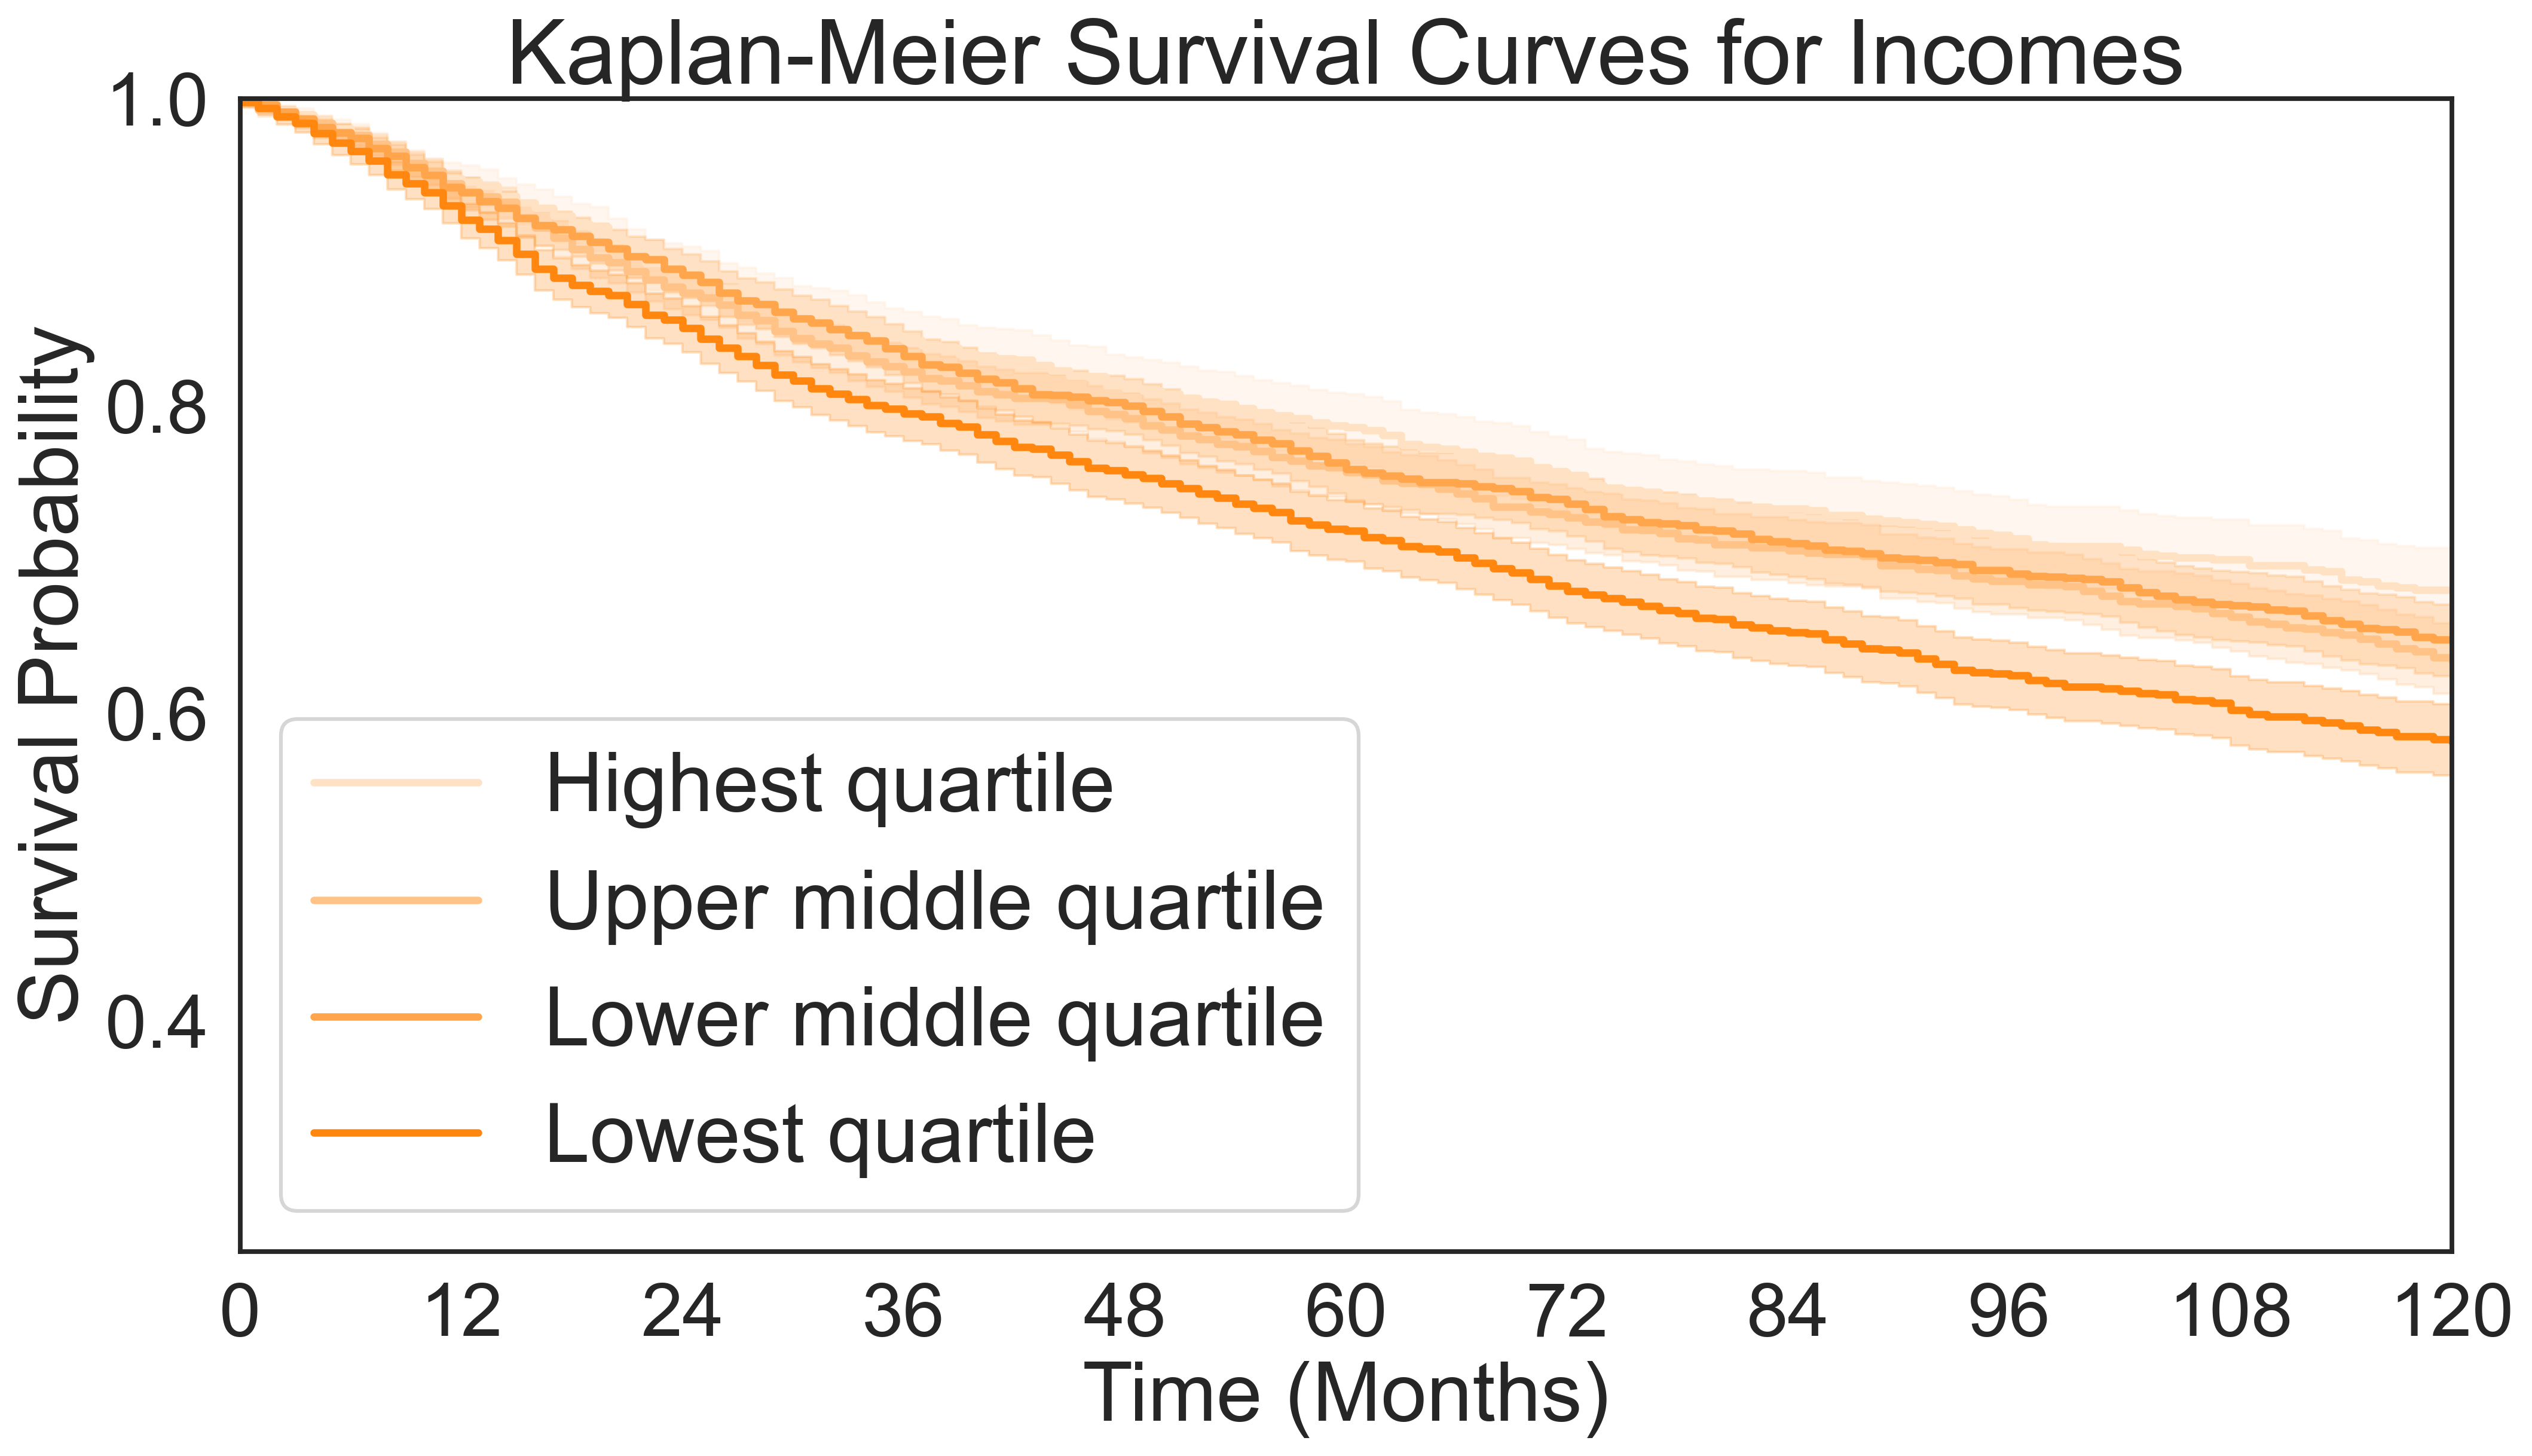

In [39]:
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
    # else 2 if x == 'Dead (missing/unknown COD)'
    else 0)

# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()
df.info()

all_races = df['Race recode (W, B, AI, API)'].unique()
main_races = ['White', 'Black', 'Asian or Pacific Islander']

df = df[df['Race recode (W, B, AI, API)'].isin(main_races)]
df['Race recode (W, B, AI, API)'] = df['Race recode (W, B, AI, API)'].cat.remove_unused_categories()
df['Race recode (W, B, AI, API)'] = df['Race recode (W, B, AI, API)'].cat.reorder_categories(['Asian or Pacific Islander','Black','White'], ordered=True)

# Make new color dictionary
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors
raceColorDict = {race: color for race, color in zip(main_races, race_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for race in main_races:
    # Filter the DataFrame for each cancer type
    df_race = df[df['Race recode (W, B, AI, API)'] == race]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_race['Survival months'], event_observed=df_race['event_occurred'], label=race)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=raceColorDict[race])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves Across Races', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = main_races

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()



## SES Based KMs


In [39]:
# First let's split the incomes into quartiles
income_col = 'Median household income inflation adj to 2022'

# # Define a function to extract numerical values from median income
# def extract_midpoint(income_str):
#     # Check if the income string represents an open-ended range (e.g., "$120,000+")
#     income_str = income_str.replace(',','')
#     if '+' in income_str:
#         # Extract the number before the '+' and return it as a float
#         return float(re.sub(r'[^\d]', '', income_str))
# 
#     # Check if the income string represents a range (e.g., "$40,000 - $44,999")
#     elif '-' in income_str:
#         # Extract the two numbers and calculate the midpoint
#         numbers = re.findall(r'\d+', income_str)
#         lower_bound = float(numbers[0])
#         upper_bound = float(numbers[1])
#         midpoint = (lower_bound + upper_bound) / 2
#         return midpoint
# 
#     # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
#     elif '<' in income_str:
#         # Extract the number and treat it as the threshold value
#         return float(re.sub(r'[^\d]', '', income_str))
# 
#     # If the string does not match any of the patterns, return NaN
#     return np.nan

# Apply the function to the income column
df['Income_numeric'] = df['Median household income inflation adj to 2022'].apply(extract_midpoint)
df['Income_numeric'] = df['Income_numeric'].astype('double')
# Step 3: Create a new column with quartile assignments
df['Income_quartile'] = pd.qcut(df['Income_numeric'], q=4, labels=["Lowest quartile", "Lower middle quartile", "Upper middle quartile", "Highest quartile"])
df['Income_quartile'] = df['Income_quartile'].cat.reorder_categories(['Highest quartile','Upper middle quartile','Lower middle quartile','Lowest quartile'],ordered=True)
print(df['Income_quartile'])
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset
income_types = df['Income_quartile'].cat.categories


# Make new color dictionary
incomeColorDict = {income_status: color for income_status, color in zip(income_types, ses_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for income_status in income_types:
    # Filter the DataFrame for each cancer type
    df_income = df[df['Income_quartile'] == income_status]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_income['Survival months'], event_observed=df_income['event_occurred'], label=income_status)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=incomeColorDict[income_status])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Incomes', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = income_types

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Sex Based KMs

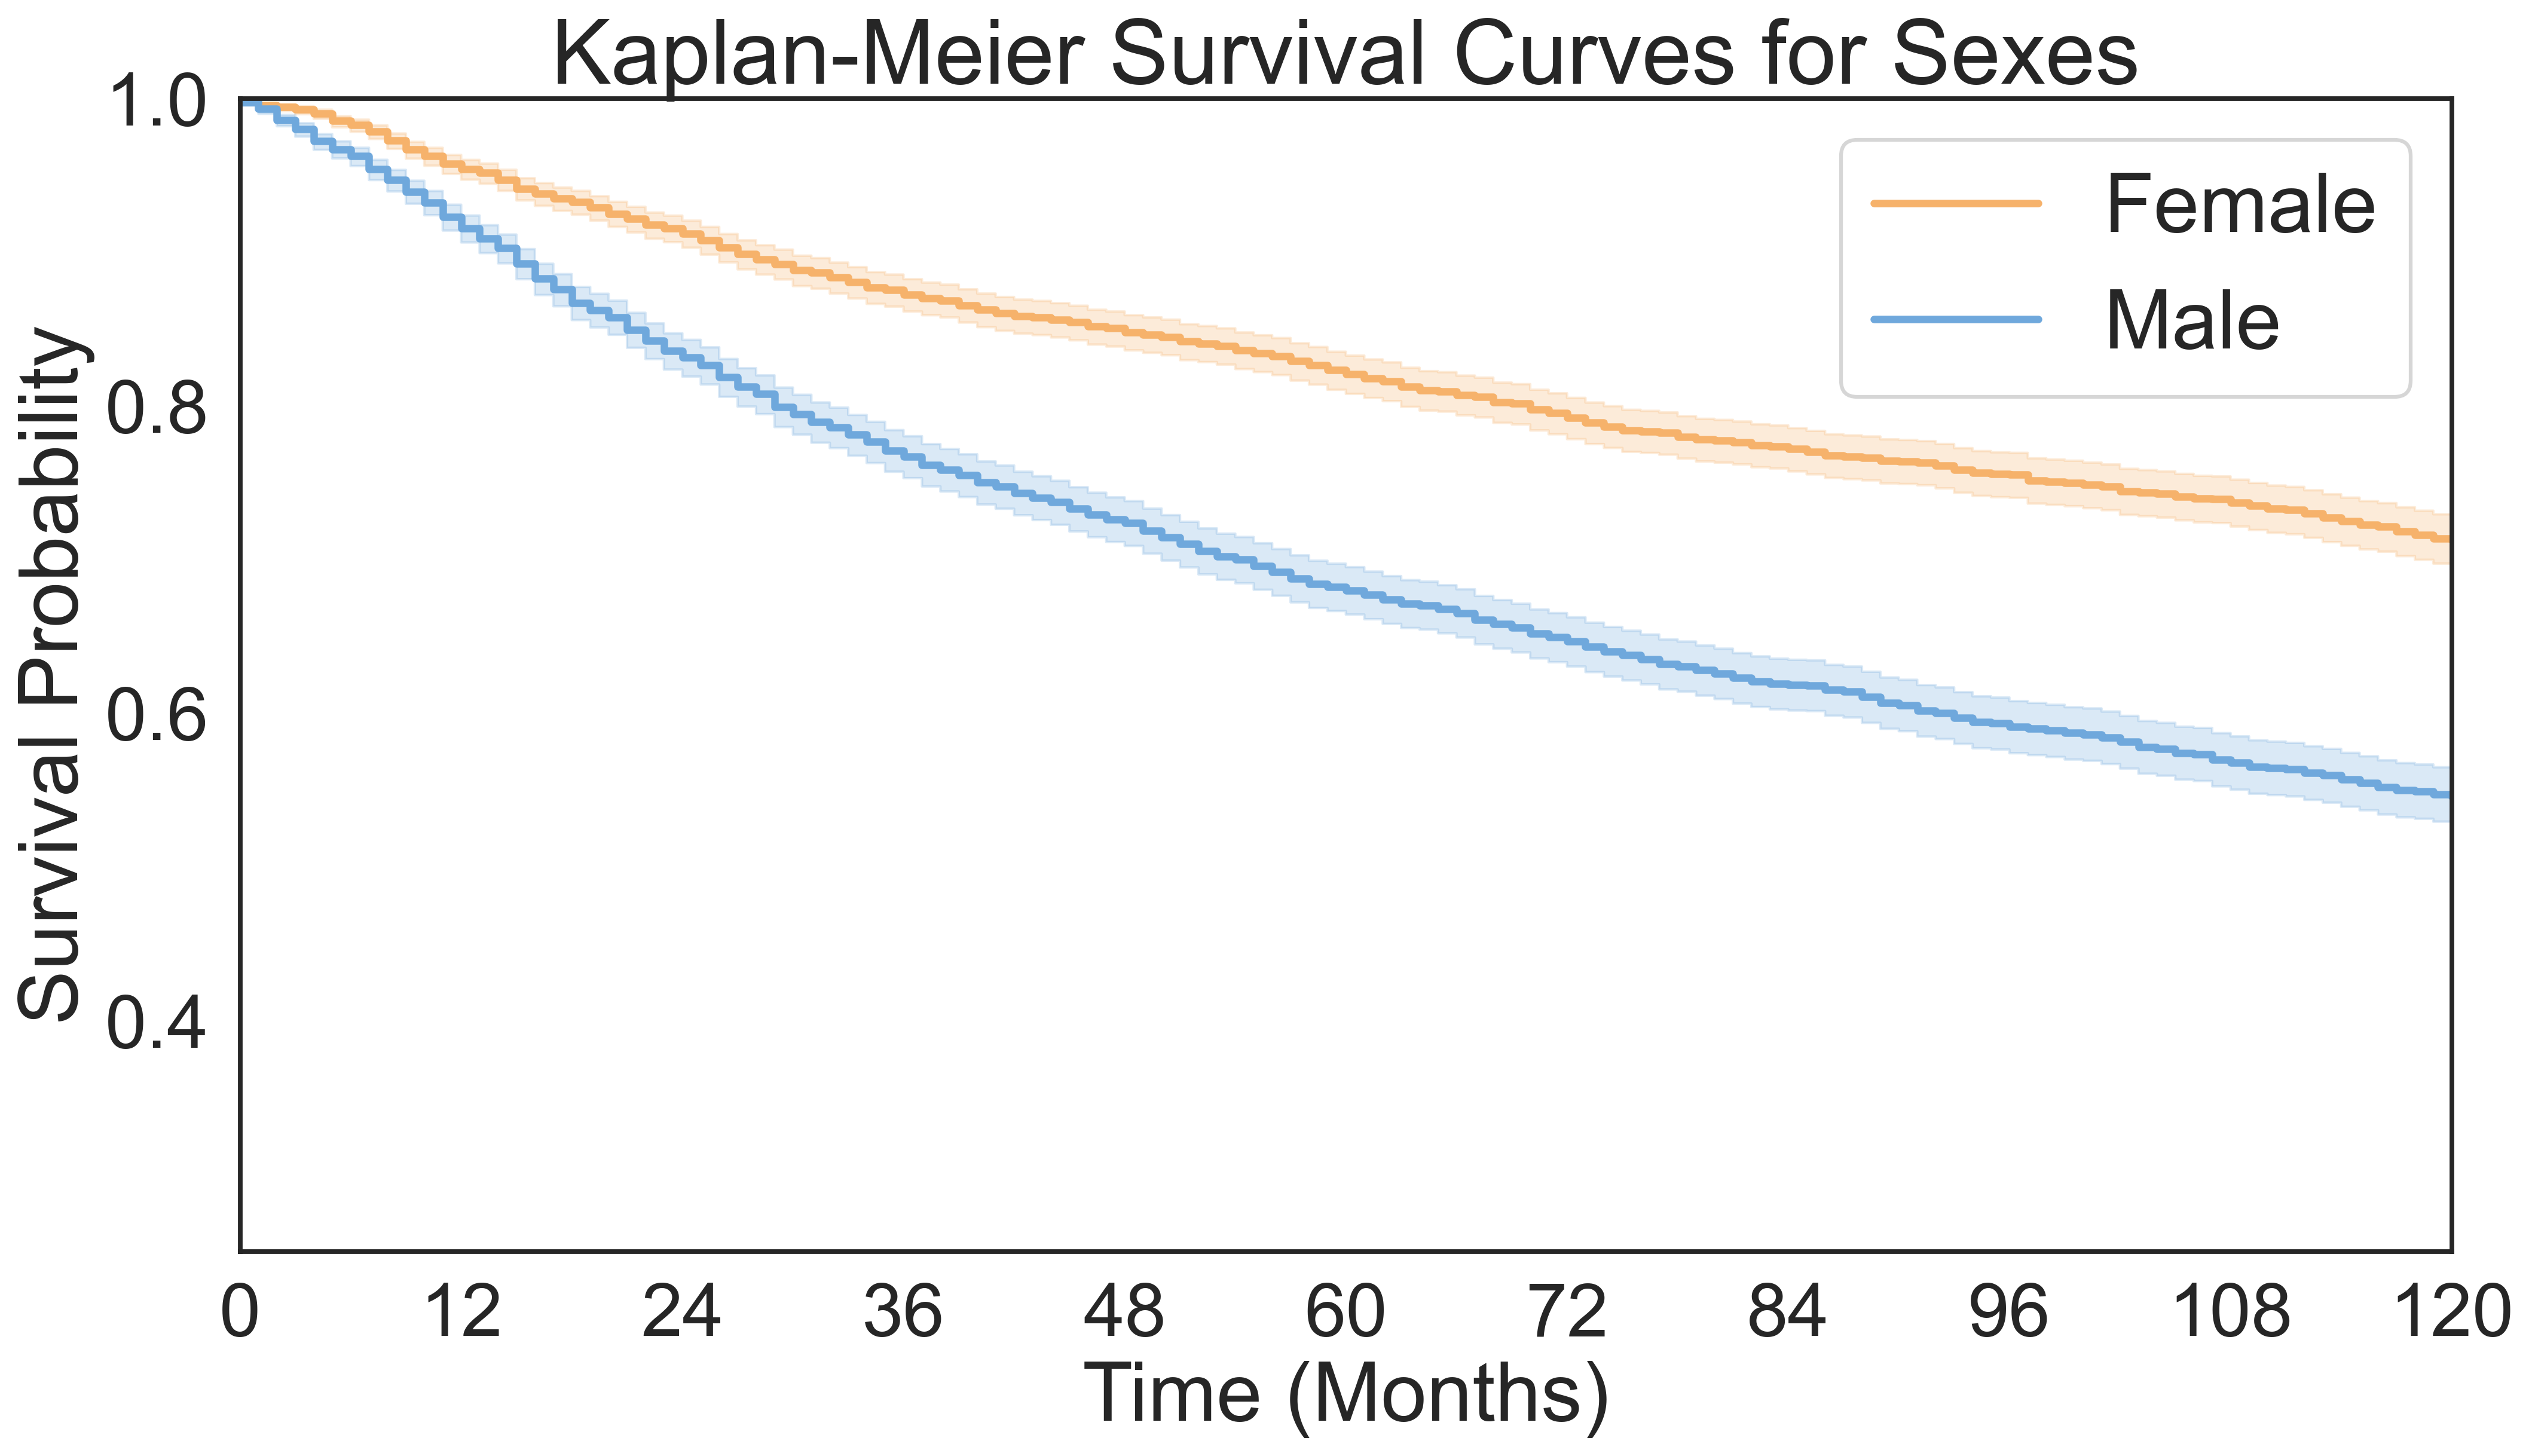

In [27]:

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset
sex_values = df['Sex'].cat.categories

# Make new color dictionary
sexColorDict = {sex: color for sex, color in zip(sex_values, sex_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for sex in sex_values:
    # Filter the DataFrame for each cancer type
    df_sex = df[df['Sex'] == sex]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_sex['Survival months'], event_observed=df_sex['event_occurred'], label=sex)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=sexColorDict[sex])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Sexes', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = sex_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Marital Status KMs

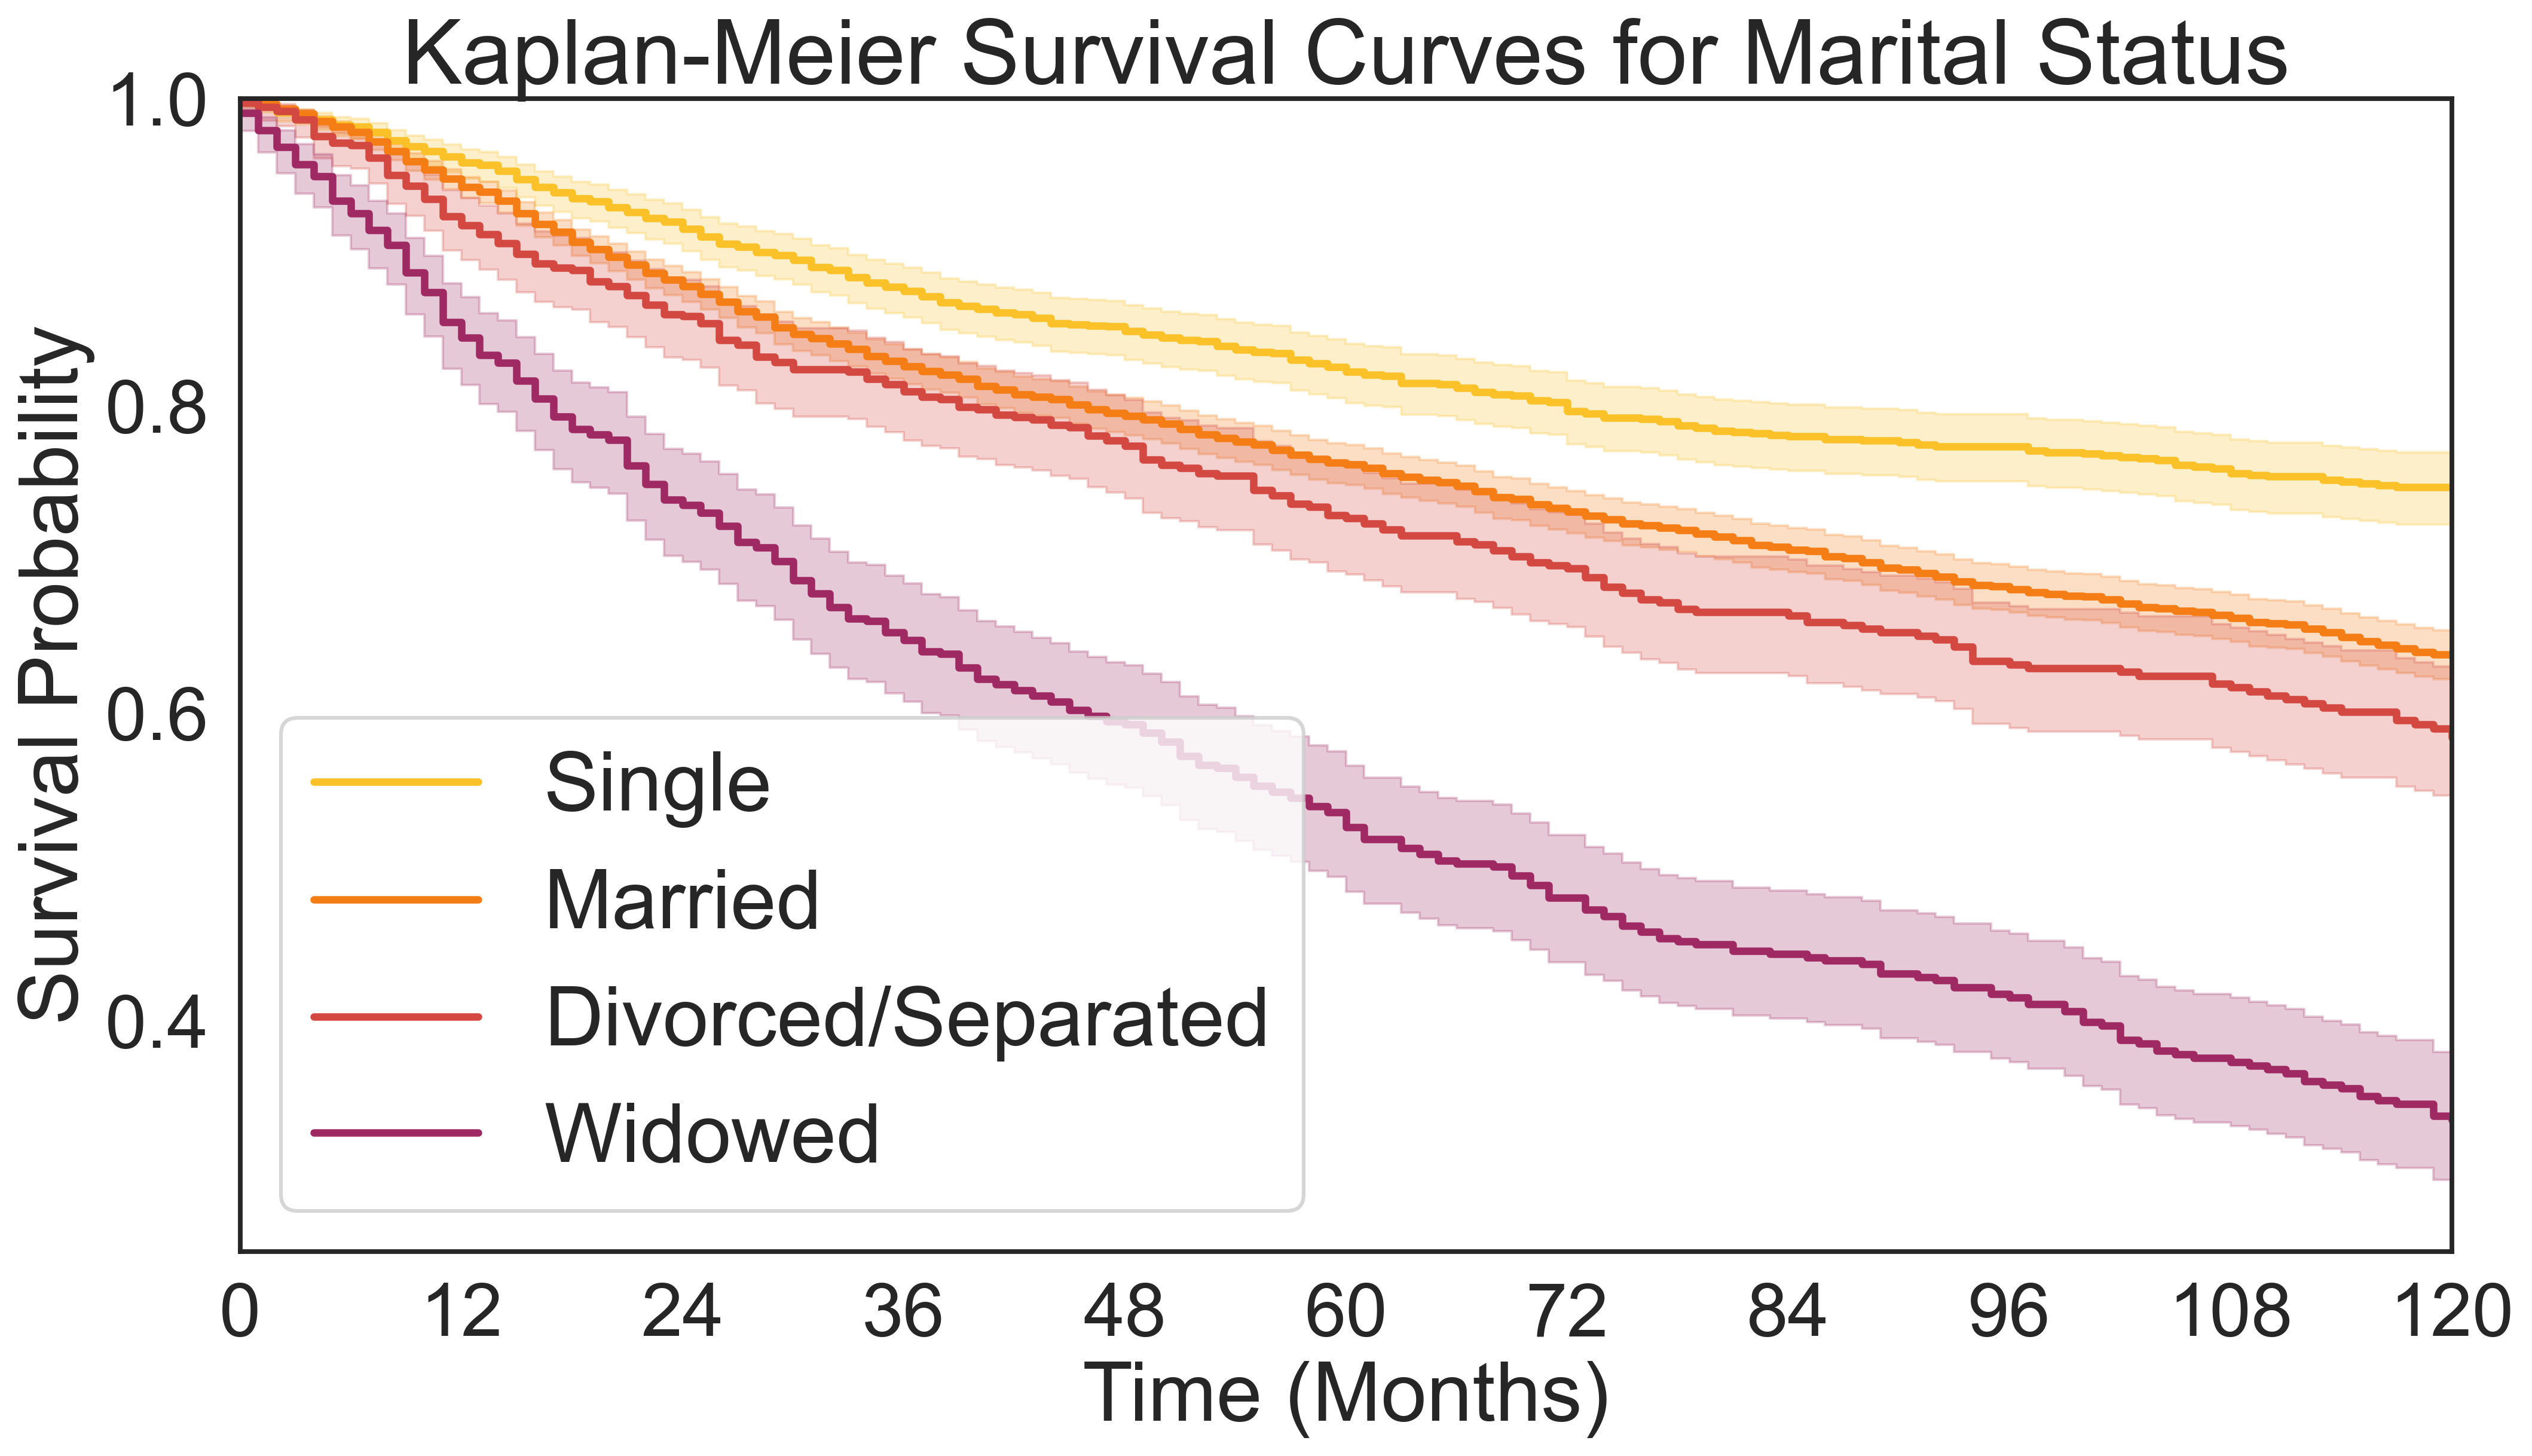

In [34]:

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Define unique marital statuses
# Check if 'Unknown' and 'Domestic Partner' exist in the categories
if {'Unknown', 'Domestic Partner'}.intersection(df[marital_colname].cat.categories):
    df[marital_colname] = df[marital_colname].cat.remove_categories(['Unknown', 'Domestic Partner'])

df[marital_colname] = df[marital_colname].cat.reorder_categories(['Single','Married','Divorced/Separated','Widowed'])

marital_values = df[marital_colname].cat.categories
# marital_values = marital_values[~marital_values.isin(['Unknown','Domestic Partner'])]
# Make new color dictionary
mSColorDict = {maritalStatus: color for maritalStatus, color in zip(marital_values, marital_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for ms in marital_values:
    # Filter the DataFrame for each cancer type
    df_ms = df[df[marital_colname] == ms]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_ms['Survival months'], event_observed=df_ms['event_occurred'], label=ms)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=mSColorDict[ms])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Marital Status', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = marital_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

# Cox Proportional Hazard Ratio

## Model 1: One-Hot Encoding

### Data Preparation including one-hot encoding and addressing collinearities

In [29]:
# Filter the dataset to include only relevant columns for the Cox model
demographic_determinants = ['Age recode with single ages and 90+', 'Sex','Histology','Marital status at diagnosis','Race recode (W, B, AI, API)','Grade Level','Income_quartile' ]

df_cox_dem = df[demographic_determinants + ['Survival months','event_occurred']] # df is used 
# df_cox_dem[marital_colname] = df_cox_dem[marital_colname].cat.remove_categories(['Unknown', 'Domestic Partner'])

# above during KM survival curves analysis
df_cox_dem = df_cox_dem[df_cox_dem['Survival months'] <= 120]

# Handle special cases in age column then rename for ease.
age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
df_cox_dem['Age recode with single ages and 90+'] = df_cox_dem['Age recode with single ages and 90+'].cat.rename_categories(age_replacement).astype(float)

df_cox_dem = df_cox_dem.rename(columns={'Race recode (W, B, AI, API)':'Race',
                                        'Age recode with single ages and 90+':'Age',
                                        'Marital status at diagnosis':'Marital Status',
                                        'Income_quartile':'Income Quartile'})

# Identify categorical columns
categorical_columns = df_cox_dem.select_dtypes(include='category').columns.tolist()

# One Hot Encoding to compare against a reference category
cox_df_onehot_coded = df_cox_dem.copy() # Copy data so as not to overwrite original table

# Ensure all categorical columns have an explicit order
for col in categorical_columns:
    # Specify the desired order for each column
    if col == 'Sex':
        df_cox_dem[col] = df_cox_dem[col].cat.reorder_categories(['Male', 'Female'], ordered=True)
    elif col == 'Histology':
        df_cox_dem[col] = df_cox_dem[col].cat.reorder_categories(
            ['Adenocarcinoma', 'Adenoid Cystic Carcinoma', 'Mucoepidermoid Carcinoma'],
            ordered=True
        )
    elif col == 'Marital Status':
        df_cox_dem[col] = df_cox_dem[col].cat.reorder_categories(
            ['Single','Married', 'Divorced/Separated', 'Widowed'],
            ordered=True
        )
    elif col == 'Race':
        df_cox_dem[col] = df_cox_dem[col].cat.reorder_categories(
            ['White', 'Black', 'Asian or Pacific Islander'],
            ordered=True
        )
    elif col == 'Grade Level':
        df_cox_dem[col] = df_cox_dem[col].cat.reorder_categories(
            ['Low', 'Intermediate', 'High', 'Unknown'],
            ordered=True
        )
    elif col == 'Income Quartile':
        df_cox_dem[col] = df_cox_dem[col].cat.reorder_categories(
            ['Lowest quartile', 'Lower middle quartile', 'Upper middle quartile', 'Highest quartile'],
            ordered=True
        )
        
# for col in categorical_columns:
#     print(df_cox_dem[col].unique())
# Perform one-hot encoding while dropping the reference category
for col in categorical_columns:
    # Create one-hot encoded variables and drop the reference category (first in order)
    dummies = pd.get_dummies(df_cox_dem[col], drop_first=True, prefix=col)

    # Add the dummy variables to the one-hot encoded dataframe
    cox_df_onehot_coded = pd.concat([cox_df_onehot_coded, dummies], axis=1)

# Drop the original categorical columns since they're now one-hot encoded
cox_df_onehot_coded = cox_df_onehot_coded.drop(columns=categorical_columns)

# Standardize Age column
scaler = StandardScaler()
cox_df_onehot_coded['Age'] = scaler.fit_transform(cox_df_onehot_coded[['Age']])

# Check the resulting dataframe
display(cox_df_onehot_coded)

Age  Survival months  event_occurred  Sex_Female  \
9      0.643835             47.0               0        True   
16     0.474436             97.0               0       False   
33     1.264964             19.0               1        True   
37     0.079172             47.0               0       False   
39     1.434363              4.0               1       False   
...         ...              ...             ...         ...   
28000 -1.163087             10.0               0       False   
28005 -1.332486              8.0               0        True   
28009  0.079172              8.0               0       False   
28014  0.700301              9.0               0        True   
28015  0.361503             11.0               0       False   

       Histology_Adenoid Cystic Carcinoma  Histology_Mucoepidermoid Carcinoma  \
9                                   False                                True   
16                                  False                               False   
33                                  False                                True   
37                                  False                                True   
39                                  False                                True   
...                                   ...                                 ...   
28000                               False                                True   
28005                               False                                True   
28009                               False                               False   
28014                               False                               False   
28015                               False                               False   

       Marital Status_Married  Marital Status_Divorced/Separated  \
9                       False                              False   
16                       True                              False   
33                       True                              False   
37                       True                              False   
39                       True                              False   
...                       ...                                ...   
28000                   False                              False   
28005                    True                              False   
28009                    True                              False   
28014                    True                              False   
28015                   False                              False   

       Marital Status_Widowed  Race_Black  Race_Asian or Pacific Islander  \
9                       False       False                           False   
16                      False       False                           False   
33                      False        True                           False   
37                      False       False                           False   
39                      False       False                           False   
...                       ...         ...                             ...   
28000                   False        True                           False   
28005                   False       False                           False   
28009                   False       False                           False   
28014                   False       False                           False   
28015                   False        True                           False   

       Grade Level_Intermediate  Grade Level_High  Grade Level_Unknown  \
9                         False             False                 True   
16                        False             False                 True   
33                        False              True                False   
37                        False             False                 True   
39                        False              True                False   
...                         ...               ...                  ...   
28000     

###  Model Fitting: One Hot Encoded

Index(['Age', 'Sex_Female', 'Histology_Adenoid Cystic Carcinoma',
       'Histology_Mucoepidermoid Carcinoma', 'Marital Status_Married',
       'Marital Status_Divorced/Separated', 'Marital Status_Widowed',
       'Race_Black', 'Race_Asian or Pacific Islander',
       'Grade Level_Intermediate', 'Grade Level_High', 'Grade Level_Unknown',
       'Income Quartile_Lower middle quartile',
       'Income Quartile_Upper middle quartile',
       'Income Quartile_Highest quartile'],
      dtype='object', name='covariate')

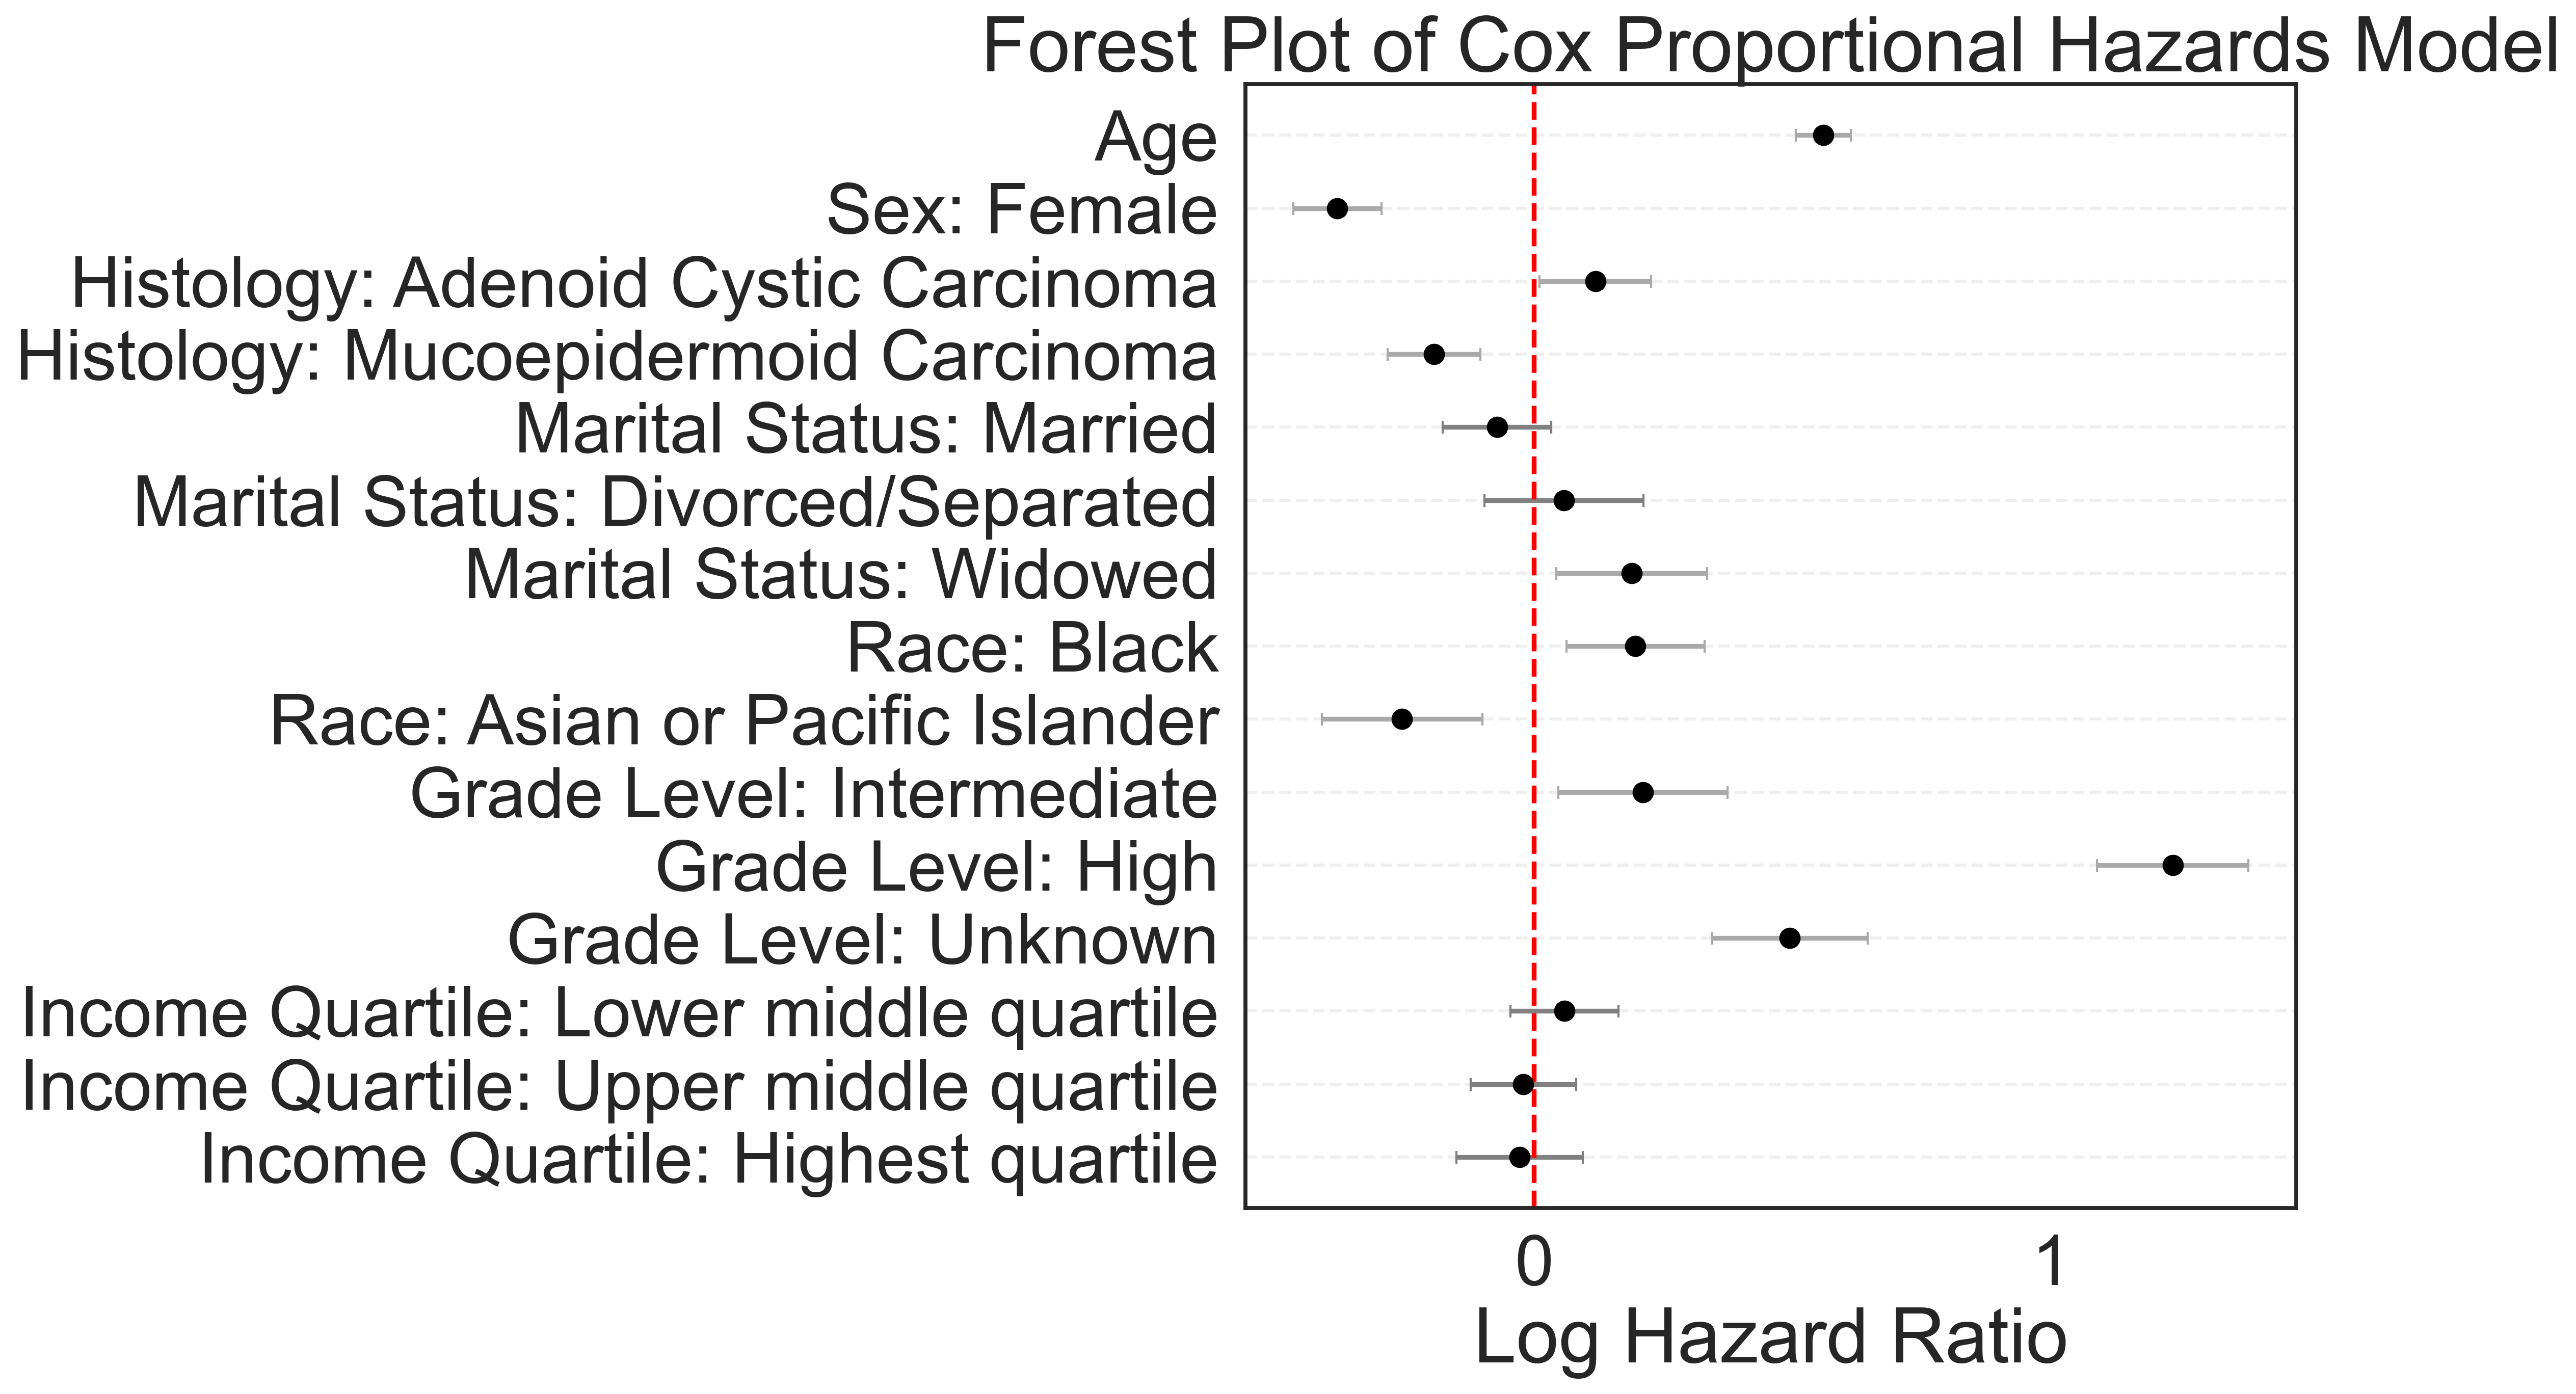

In [30]:
# Fit Cox model
cox_model = CoxPHFitter(penalizer=0.01)
cox_model.fit(cox_df_onehot_coded, duration_col='Survival months', event_col='event_occurred')
# 
# Export summary
cox_summary = cox_model.summary
output_file_path = 'onehot_cox_summary.xlsx'
cox_summary.to_excel(output_file_path)
# 
# Extract coefficients, confidence intervals, and p-values
coef = cox_model.summary['coef']
lower_ci = cox_model.summary['coef lower 95%']
upper_ci = cox_model.summary['coef upper 95%']
p_values = cox_model.summary['p']
variables = coef.index
# 
display(variables)
# cox_summary

# 
# Define the order and reverse it
# Replace underscores with ": " in all variable names
formatted_variables = [varname.replace('_', ': ') for varname in variables]
formatted_variables = formatted_variables[::-1]
order = variables
order = order[::-1]
# 
# Reorder coefficients and confidence intervals and convert to hazard ratios
# coefficients_ordered = np.exp(np.array([coef[label] for label in order]))
# lower_ci_ordered = np.exp(np.array([lower_ci[label] for label in order]))
# upper_ci_ordered = np.exp(np.array([upper_ci[label] for label in order]))
# xlineval = 1
# xlabelval = 'Hazard Ratio'

# Reorder coefficients and confidence intervals and don't convert to hazard ratios
coefficients_ordered = (np.array([coef[label] for label in order]))
lower_ci_ordered = (np.array([lower_ci[label] for label in order]))
upper_ci_ordered = (np.array([upper_ci[label] for label in order]))
xlineval = 0
xlabelval = 'Log Hazard Ratio'

# Highlight significant p-values
significant = p_values < 0.05

# Error bars
errors_ordered = [coefficients_ordered - lower_ci_ordered, upper_ci_ordered - coefficients_ordered]

# Plot setup
fig, ax = plt.subplots(figsize=(16, 10))

# Plot with significant points highlighted
for i, label in enumerate(order):
    if significant[label]:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='darkgrey', capsize=3)  # Significant in red
    else:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='grey', capsize=3)

# Add a vertical line for hazard ratio = 1
plt.axvline(x=xlineval, color='red', linestyle='--')

# Update the y-tick labels to the new labels, in the specified order
ax.set_yticks(range(len(order)))
ax.set_yticklabels(formatted_variables)

# Set X-axis
# plt.xlim(-.25,2.25)

# Customize the plot
plt.xlabel(xlabelval)
plt.title('Forest Plot of Cox Proportional Hazards Model')

# Add gridlines for y-axis (horizontal lines)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('cox_forest_plot.png', dpi=300, bbox_inches='tight')  # Save the plot as a PNG file

# Show the plot
plt.show()

## Model 2: Effect (Deviation) Coding

### Data preparation and effect coding for demographic determinants

In [31]:
# Filter the dataset to include only relevant columns for the Cox model
demographic_determinants = ['Age recode with single ages and 90+', 'Sex','Histology','Marital status at diagnosis','Race recode (W, B, AI, API)','Grade Level','Income_quartile' ]

df_cox_dem = df[demographic_determinants + ['Survival months','event_occurred']] # df is used above during KM survival curves analysis
df_cox_dem = df_cox_dem[df_cox_dem['Survival months'] <= 120]

# Handle special cases in age column then rename for ease.
age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
df_cox_dem['Age recode with single ages and 90+'] = df_cox_dem['Age recode with single ages and 90+'].cat.rename_categories(age_replacement).astype(float)

df_cox_dem = df_cox_dem.rename(columns={'Race recode (W, B, AI, API)':'Race', 
                                        'Age recode with single ages and 90+':'Age',
                                        'Marital status at diagnosis':'Marital Status',
                                        'Income_quartile':'Income Quartile'})

# Identify categorical columns
categorical_columns = df_cox_dem.select_dtypes(include='category').columns.tolist()

# Due to the retention of all categories within each categorical variable, we will get perfect collinearity, causing a singularity in the Proportional Hazards analysis. We want to compare against the overall mean hazard, which will resolve the collinearity issue.
cox_df_effect_coded = df_cox_dem.copy() # Copy data so as not to overwrite original table

# Deviation coding -- generate dummy variables (retain all), then enforce sum-to-zero constraint for deviation encoding
for col in categorical_columns:
    # Update categories to prepend the column name
    cox_df_effect_coded[col] = cox_df_effect_coded[col].cat.rename_categories(lambda x: f"{col}: {x}")
    
    # Create dummy variables for the categories
    dummies = pd.get_dummies(cox_df_effect_coded[col], drop_first=False)
    
    # Subtract the row mean across the dummies to enforce sum-to-zero constraint
    deviation_coded = dummies.sub(dummies.mean(axis=1), axis=0)
    
    # Add deviation-coded columns back to the DataFrame
    cox_df_effect_coded = pd.concat([cox_df_effect_coded,deviation_coded], axis=1)

scaler = StandardScaler()
cox_df_effect_coded['Age'] = scaler.fit_transform(cox_df_effect_coded[['Age']])

cox_df_effect_coded = cox_df_effect_coded.drop(categorical_columns, axis=1)
display(cox_df_effect_coded)
print(cox_df_effect_coded.columns)


Age  Survival months  event_occurred  Sex: Female  Sex: Male  \
9      0.643835             47.0               0          0.5       -0.5   
16     0.474436             97.0               0         -0.5        0.5   
33     1.264964             19.0               1          0.5       -0.5   
37     0.079172             47.0               0         -0.5        0.5   
39     1.434363              4.0               1         -0.5        0.5   
...         ...              ...             ...          ...        ...   
28000 -1.163087             10.0               0         -0.5        0.5   
28005 -1.332486              8.0               0          0.5       -0.5   
28009  0.079172              8.0               0         -0.5        0.5   
28014  0.700301              9.0               0          0.5       -0.5   
28015  0.361503             11.0               0         -0.5        0.5   

       Histology: Adenocarcinoma  Histology: Adenoid Cystic Carcinoma  \
9                      -0.333333                            -0.333333   
16                      0.666667                            -0.333333   
33                     -0.333333                            -0.333333   
37                     -0.333333                            -0.333333   
39                     -0.333333                            -0.333333   
...                          ...                                  ...   
28000                  -0.333333                            -0.333333   
28005                  -0.333333                            -0.333333   
28009                   0.666667                            -0.333333   
28014                   0.666667                            -0.333333   
28015                   0.666667                            -0.333333   

       Histology: Mucoepidermoid Carcinoma  Marital Status: Single  \
9                                 0.666667                    0.75   
16                               -0.333333                   -0.25   
33                                0.666667                   -0.25   
37                                0.666667                   -0.25   
39                                0.666667                   -0.25   
...                                    ...                     ...   
28000                             0.666667                    0.75   
28005                             0.666667                   -0.25   
28009                            -0.333333                   -0.25   
28014                            -0.333333                   -0.25   
28015                            -0.333333                    0.75   

       Marital Status: Married  ...  Race: Black  Race: White  \
9                        -0.25  ...    -0.333333     0.666667   
16                        0.75  ...    -0.333333     0.666667   
33                        0.75  ...     0.666667    -0.333333   
37                        0.75  ...    -0.333333     0.666667   
39                        0.75  ...    -0.333333     0.666667   
...                        ...  ...          ...          ...   
28000                    -0.25  ...     0.666667    -0.333333   
28005                     0.75  ...    -0.333333     0.666667   
28009                     0.75  ...    -0.333333     0.666667   
28014                     0.75  ...    -0.333333     0.666667   
28015                    -0.25  ...     0.666667    -0.333333   

       Grade Level: Low  Grade Level: Intermediate  Grade Level: High  \
9                 -0.25                      -0.25              -0.25   
16                -0.25                      -0.25              -0.25   
33                -0.25                      -0.25               0.75   
37                -0.25                      -0.25              -0.25   
39                -0.25                      -0.25               0.75   
...                 ...                        ...                ...   
28000             -0.25                      -0.25              -0.25   
28005           

Index(['Age', 'Survival months', 'event_occurred', 'Sex: Female', 'Sex: Male',
       'Histology: Adenocarcinoma', 'Histology: Adenoid Cystic Carcinoma',
       'Histology: Mucoepidermoid Carcinoma', 'Marital Status: Single',
       'Marital Status: Married', 'Marital Status: Divorced/Separated',
       'Marital Status: Widowed', 'Race: Asian or Pacific Islander',
       'Race: Black', 'Race: White', 'Grade Level: Low',
       'Grade Level: Intermediate', 'Grade Level: High',
       'Grade Level: Unknown', 'Income Quartile: Highest quartile',
       'Income Quartile: Upper middle quartile',
       'Income Quartile: Lower middle quartile',
       'Income Quartile: Lowest quartile'],
      dtype='object')


### Model Fitting (Effect Coded)

coef  exp(coef)  se(coef)  \
covariate                                                               
Age                                     0.564160   1.757970  0.027182   
Sex: Female                            -0.189659   0.827242  0.190016   
Sex: Male                               0.189659   1.208837  0.190016   
Histology: Adenocarcinoma               0.045407   1.046453  0.170108   
Histology: Adenoid Cystic Carcinoma     0.163819   1.178001  0.173029   
Histology: Mucoepidermoid Carcinoma    -0.143550   0.866277  0.170388   
Marital Status: Single                  0.026883   1.027248  0.182950   
Marital Status: Married                -0.084780   0.918714  0.179536   
Marital Status: Divorced/Separated      0.025677   1.026010  0.187044   
Marital Status: Widowed                 0.161266   1.174997  0.185717   
Race: Asian or Pacific Islander        -0.239612   0.786933  0.229991   
Race: Black                             0.207752   1.230908  0.228087   
Race: White                             0.013311   1.013400  0.223918   
Grade Level: Low                       -0.653563   0.520189  0.175925   
Grade Level: Intermediate              -0.331480   0.717861  0.168232   
Grade Level: High                       0.688235   1.990200  0.165241   
Grade Level: Unknown                   -0.047559   0.953554  0.164965   
Income Quartile: Highest quartile      -0.032343   0.968174  0.161346   
Income Quartile: Upper middle quartile -0.023729   0.976551  0.158445   
Income Quartile: Lower middle quartile  0.057010   1.058666  0.159214   
Income Quartile: Lowest quartile        0.000902   1.000903  0.158231   

                                        coef lower 95%  coef upper 95%  \
covariate                                                                
Age                                           0.510883        0.617437   
Sex: Female                                  -0.562084        0.182767   
Sex: Male                                    -0.182767        0.562084   
Histology: Adenocarcinoma                    -0.287998        0.378811   
Histology: Adenoid Cystic Carcinoma          -0.175311        0.502949   
Histology: Mucoepidermoid Carcinoma          -0.477504        0.190403   
Marital Status: Single                       -0.331692        0.385459   
Marital Status: Married                      -0.436665        0.267105   
Marital Status: Divorced/Separated           -0.340923        0.392278   
Marital Status: Widowed                      -0.202733        0.525264   
Race: Asian or Pacific Islander              -0.690387        0.211162   
Race: Black                                  -0.239290        0.654795   
Race: White                                  -0.425561        0.452184   
Grade Level: Low                             -0.998370       -0.308757   
Grade Level: Intermediate                    -0.661209       -0.001750   
Grade Level: High                             0.364368        1.012102   
Grade Level: Unknown                         -0.370885        0.275767   
Income Quartile: Highest quartile            -0.348576        0.283890   
Income Quartile: Upper middle quartile       -0.334275        0.286817   
Income Quartile: Lower middle quartile       -0.255043        0.369062   
Income Quartile: Lowest quartile             -0.309225        0.311030   

                                        exp(coef) lower 95%  \
covariate                                                     
Age                                                1.666763   
Sex: Female                                        0.570020   
Sex: Male                                          0.832962   
Histology: Adenocarcinoma                          0.749763   
Histology: Adenoid Cystic Carcinoma                0.839196   
Histology: Mucoepidermoid Carcinoma                0.620330   
Marital Status: Single                             0.717708   
Marital Status: Married                            0.646188   
Marital Status: Divorced/Separa

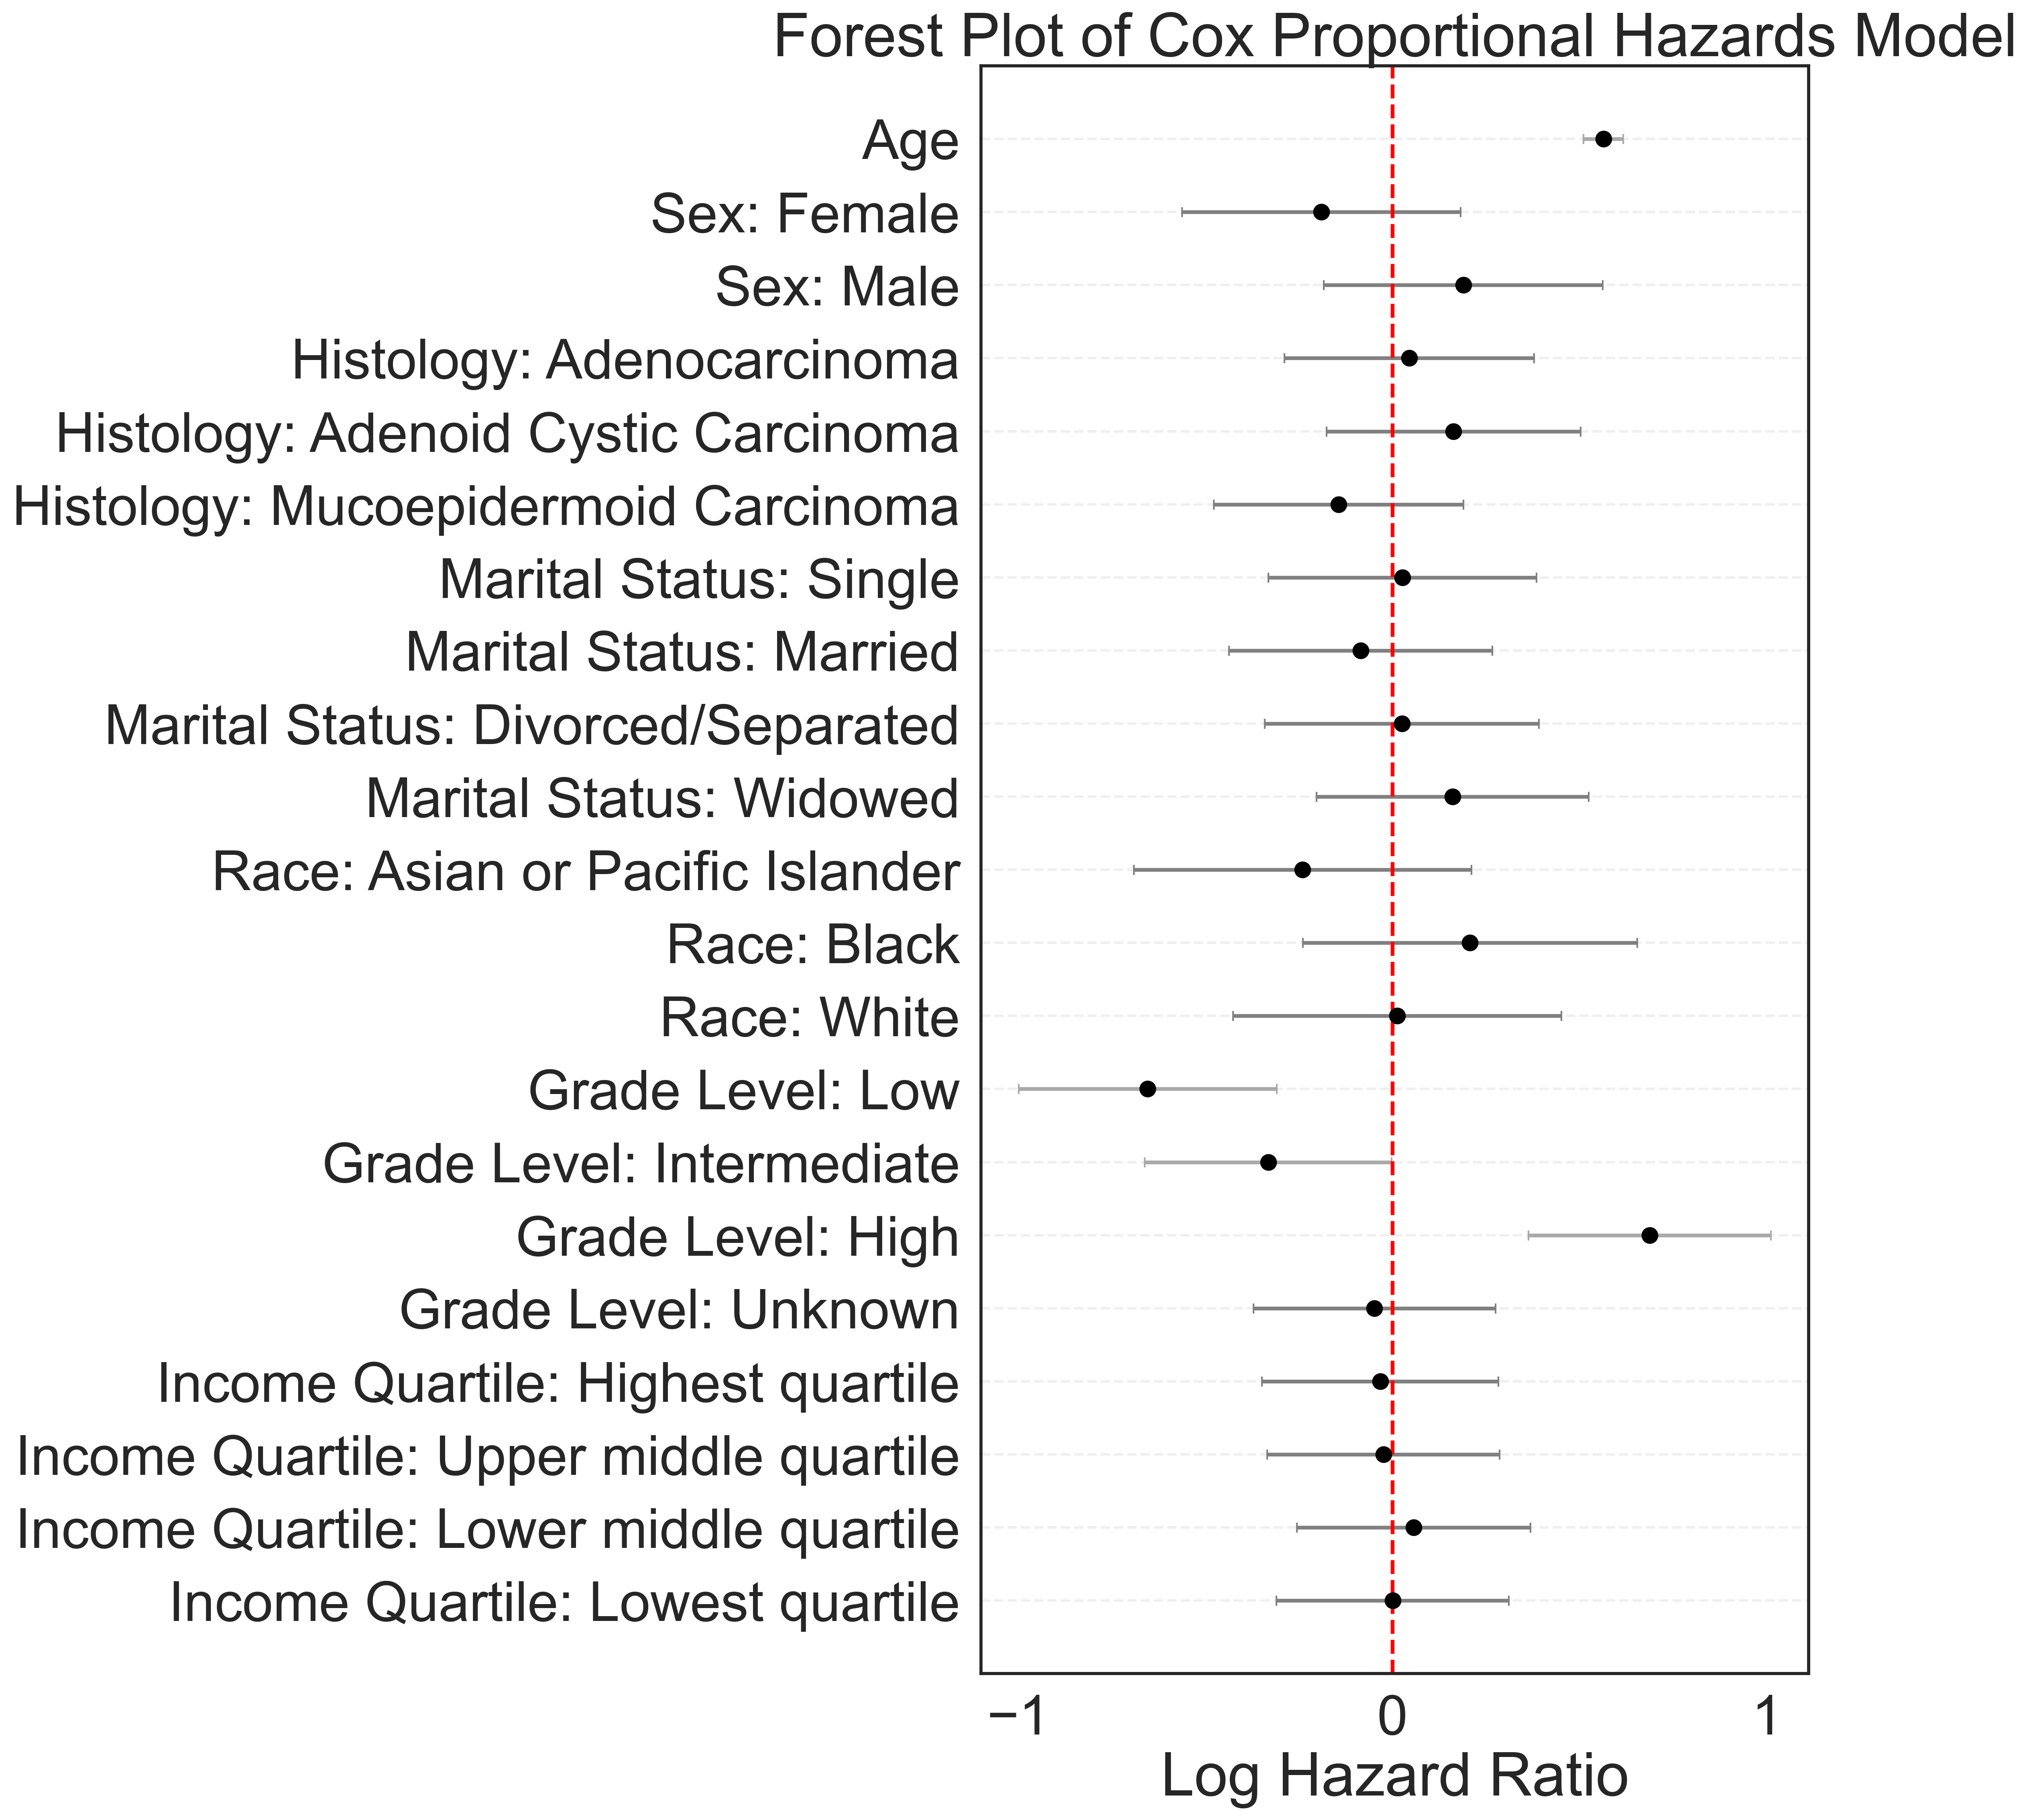

In [32]:
# Fit the Cox model
cox_model = CoxPHFitter(penalizer=0.01)
cox_model.fit(cox_df_effect_coded, duration_col='Survival months', event_col='event_occurred')

# Print the summary
eff_coded_cox_summary = cox_model.summary
output_file_path = 'eff_coded_cox_summary.xlsx'
eff_coded_cox_summary.to_excel(output_file_path)

# Extract coefficients, confidence intervals, and p-values
coef = eff_coded_cox_summary['coef']
lower_ci = eff_coded_cox_summary['coef lower 95%']
upper_ci = eff_coded_cox_summary['coef upper 95%']
p_values = eff_coded_cox_summary['p']
variables = coef.index
display(eff_coded_cox_summary)

devenc_order = eff_coded_cox_summary.index.to_list()
devenc_order = devenc_order[::-1]


# Reorder coefficients and confidence intervals and don't convert to hazard ratios
coefficients_ordered = (np.array([coef[label] for label in devenc_order]))
lower_ci_ordered = (np.array([lower_ci[label] for label in devenc_order]))
upper_ci_ordered = (np.array([upper_ci[label] for label in devenc_order]))
xlineval = 0
xlabelval = 'Log Hazard Ratio'

# Highlight significant p-values
significant = p_values < 0.05

# Error bars
errors_ordered = [coefficients_ordered - lower_ci_ordered, upper_ci_ordered - coefficients_ordered]

# Plot setup
fig, ax = plt.subplots(figsize=(16, 16))

# Plot with significant points highlighted
for i, label in enumerate(devenc_order):
    if significant[label]:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='darkgrey', capsize=3)  # Significant in red
    else:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='grey', capsize=3)

# Add a vertical line for hazard ratio = 1
plt.axvline(x=xlineval, color='red', linestyle='--')

# Update the y-tick labels to the new labels, in the specified order
ax.set_yticks(range(len(devenc_order)))
ax.set_yticklabels([label for label in devenc_order])

# Set X-axis
# plt.xlim(-.25,2.25)

# Customize the plot
plt.xlabel(xlabelval)
plt.title('Forest Plot of Cox Proportional Hazards Model')

# Add gridlines for y-axis (horizontal lines)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('cox_effcoded_forest_plot.png', dpi=300, bbox_inches='tight')  # Save the plot as a PNG file

# Show the plot
plt.show()


# Being Male as a Risk Factor? Sex and Grade Level

In [33]:

# Group by 'Sex' and 'Grade Label' and sort based on the defined order
result = (
    cox_df_updated[['Sex', 'Histology', 'Grade Level']]
    .groupby('Sex', observed=False)['Grade Level']
    .value_counts()
    .sort_index(level=['Sex', 'Grade Level'])
)
print(result)
# Convert the result to a DataFrame and reset index
result_df = result.reset_index()
display(result_df)
# Plot the result using seaborn
plt.figure(figsize=(20, 15))
sns.barplot(
    data=result_df,
    x='Grade Level',
    y='count',
    hue='Sex',
    palette='RdBu'
)

# Set labels and title
plt.xlabel('Grade')
plt.ylabel('Number of Cases')
# plt.title('Counts of Grade Level by Sex')

# Save & Display the plot
plt.tight_layout()
plt.savefig('FvM_GradeCounts.png',dpi=300,bbox_inches='tight')
plt.show()


NameError: name 'cox_df_updated' is not defined

# Race and Grade Level

In [ ]:
# Group by 'Race' and 'Grade Label' and sort based on the defined order
result = (
    cox_df_updated[['Race recode (W, B, AI, API)', 'Grade Level']]
    .groupby('Race recode (W, B, AI, API)', observed=False)['Grade Level']
    .value_counts()
    .sort_index(level=['Race recode (W, B, AI, API)', 'Grade Level'])
)
print(result)
# Convert the result to a DataFrame and reset index
result_df = result.reset_index()
display(result_df)
# Plot the result using seaborn
plt.figure(figsize=(20, 15))
sns.barplot(
    data=result_df,
    x='Grade Level',
    y='count',
    hue='Race recode (W, B, AI, API)',
    palette='rocket_r'
)

# Set labels and title
plt.xlabel('Grade')
plt.ylabel('Number of Cases')
# plt.title('Counts of Grade Level by Sex')

# Save & Display the plot
plt.tight_layout()
plt.savefig('Race_GradeCounts.png',dpi=300,bbox_inches='tight')
plt.show()


# Race and Income

In [ ]:
result_total = (
    cox_df_updated[['Race recode (W, B, AI, API)', 'Income_above_below_median', 'event_occurred']]
    .groupby('Race recode (W, B, AI, API)', observed=False)[['Income_above_below_median']]
    .value_counts()
    .sort_index(level=['Race recode (W, B, AI, API)', 'Income_above_below_median'])
)

result_survival = (
    cox_df_updated[['Race recode (W, B, AI, API)', 'Income_above_below_median', 'event_occurred']]
    .groupby('Race recode (W, B, AI, API)', observed=False)[['Income_above_below_median','event_occurred']]
    .value_counts()
    .sort_index(level=['Race recode (W, B, AI, API)', 'Income_above_below_median'])
)
# Convert the result to a DataFrame and reset index
result_df_total = result_total.reset_index()
# display(result_df_total)

result_df_survival = result_survival.reset_index()
# display(result_df_survival)

# Plot the result using seaborn
plt.figure(figsize=(20, 15))

# Generate the 'rocket_r' palette
rocket_palette = sns.color_palette("rocket_r", n_colors=10)
# Generate alternative slate of palettes
darkened_palette = sns.color_palette(rocket_palette[0:10:2], desat=.2)  # desat < 1 brightens the colors

# Create a count plot to visualize the counts with stacking by event_occurred and race differentiation
bp_total = sns.barplot(
    data=result_df_total,
    x='Income_above_below_median',  # X-axis is income above/below median
    y='count',  # Y-axis is the count of individuals
    hue='Race recode (W, B, AI, API)',  # Use race as the hue to differentiate the bars
    palette=rocket_palette[0:10:2],
    edgecolor='black',
    linewidth=2,
)

# Overlay a second bar plot for event_occurred (alive vs not alive) for stacked effect
bp_dead = sns.barplot(
    data=result_df_survival[result_df_survival['event_occurred']==1],
    x='Income_above_below_median',
    y='count',
    hue='Race recode (W, B, AI, API)',  # Use event_occurred to fill the bars for alive vs not alive
    palette=darkened_palette,
    edgecolor='black',
    linewidth=2,
    legend=False
)

plt.xlabel('Income')
plt.ylabel('Number of Cases')

# Adjust the legend fontsize
xlabel_fontsize = bp_total.xaxis.label.get_size()
plt.legend(fontsize=xlabel_fontsize * .7)  # Change legend fontsize and title fontsize

# Save & Display the plot
plt.tight_layout()
plt.savefig('Race_IncomeAboveBelowMedian.png',dpi=300,bbox_inches='tight')
plt.show()


# Logistic Regression
### Can we predict which patients are likely to die?

In [ ]:
# target variable
y = cox_df_updated_encoded['event_occurred']  # Use 'event_occurred' as the binary outcome variable

# Drop the target column from the feature set
X = cox_df_updated_encoded.drop(['event_occurred'], axis=1)

# Split the data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=69)

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Predict on the test data
y_pred_log = log_reg.predict(X_test)

# Evaluate the Logistic Regression model
print("Logistic Regression Classifier Evaluation:")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

# ROC-AUC Score
log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score for Logistic Regression: {log_reg_roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {log_reg_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Random Forest Classifier

In [ ]:
# rf_clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)

# 
# # Fit the model on the training data
# rf_clf.fit(X_train, y_train)
# 
# # Predict on the test data
# y_pred_rf = rf_clf.predict(X_test)
# 
# # Evaluate the Random Forest Classifier
# print("Random Forest Classifier Evaluation:")
# print(classification_report(y_test, y_pred_rf))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))

# # ROC-AUC Score for Random Forest
# rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
# print(f"ROC-AUC Score for Random Forest: {rf_roc_auc}")
# 
# # Plot ROC curve for Random Forest
# fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
# plt.figure(figsize=(10, 6))
# plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Random Forest')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier()

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 300],  # Number of trees
    'max_depth': [None, 5,6,7,8,9,10],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Set up Randomized Search (search over 20 different combinations)
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring='roc_auc', verbose=2, random_state=69)

# Fit the Randomized Search model
random_search_rf.fit(X_train, y_train)

# Best parameters found by Randomized Search
print("Best parameters for Random Forest:", random_search_rf.best_params_)

# Make predictions using the best model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Evaluation after Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))



# Calculate the ROC-AUC score using the best_rf_model (the fitted model from RandomizedSearchCV)
rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score for Random Forest: {rf_roc_auc}")

# Plot the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()